In [156]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

from dotenv import load_dotenv
load_dotenv()

%matplotlib inline

In [157]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [158]:
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [159]:
data_path = os.getenv('data_path')
df_weather = pd.read_csv(fr'{data_path}\weather_features.csv')
df_energy = pd.read_csv(fr'{data_path}\energy_dataset.csv')

In [160]:
df_energy.tail(5)

time  generation biomass  \
35059  2018-12-31 19:00:00+01:00               297.0   
35060  2018-12-31 20:00:00+01:00               296.0   
35061  2018-12-31 21:00:00+01:00               292.0   
35062  2018-12-31 22:00:00+01:00               293.0   
35063  2018-12-31 23:00:00+01:00               290.0   

       generation fossil brown coal/lignite  \
35059                                   0.0   
35060                                   0.0   
35061                                   0.0   
35062                                   0.0   
35063                                   0.0   

       generation fossil coal-derived gas  generation fossil gas  \
35059                                 0.0                 7634.0   
35060                                 0.0                 7241.0   
35061                                 0.0                 7025.0   
35062                                 0.0                 6562.0   
35063                                 0.0                 6926.0   

       generation fossil hard coal  generation fossil oil  \
35059                       2628.0                  178.0   
35060                       2566.0                  174.0   
35061                       2422.0                  168.0   
35062                       2293.0                  163.0   
35063                       2166.0                  163.0   

       generation fossil oil shale  generation fossil peat  \
35059                          0.0                     0.0   
35060                          0.0                     0.0   
35061                          0.0                     0.0   
35062                          0.0                     0.0   
35063                          0.0                     0.0   

       generation geothermal  ...  generation waste  generation wind offshore  \
35059                    0.0  ...             277.0                       0.0   
35060                    0.0  ...             280.0                       0.0   
35061                    0.0  ...             286.0                       0.0   
35062                    0.0  ...             287.0                       0.0   
35063                    0.0  ...             287.0                       0.0   

       generation wind onshore  forecast solar day ahead  \
35059                   3113.0                      96.0   
35060                   3288.0                      51.0   
35061                   3503.0                      36.0   
35062                   3586.0                      29.0   
35063                   3651.0                      26.0   

       forecast wind offshore eday ahead  forecast wind onshore day ahead  \
35059                                NaN                           3253.0   
35060                                NaN                           3353.0   
35061                                NaN                           3404.0   
35062                                NaN                           3273.0   
35063                                NaN                           3117.0   

       total load forecast  total load actual  price day ahead  price actual  
35059              30619.0            30653.0            68.85         77.02  
35060              29932.0            29735.0            68.40         76.16  
35061              27903.0            28071.0            66.88         74.30  
35062              25450.0            25801.0            63.93         69.89  
35063              24424.0            24455.0            64.27         69.88  

[5 rows x 29 columns]

In [161]:
df_energy.describe().T.round(2)

count      mean      std  \
generation biomass                           35045.0    383.51    85.35   
generation fossil brown coal/lignite         35046.0    448.06   354.57   
generation fossil coal-derived gas           35046.0      0.00     0.00   
generation fossil gas                        35046.0   5622.74  2201.83   
generation fossil hard coal                  35046.0   4256.07  1961.60   
generation fossil oil                        35045.0    298.32    52.52   
generation fossil oil shale                  35046.0      0.00     0.00   
generation fossil peat                       35046.0      0.00     0.00   
generation geothermal                        35046.0      0.00     0.00   
generation hydro pumped storage aggregated       0.0       NaN      NaN   
generation hydro pumped storage consumption  35045.0    475.58   792.41   
generation hydro run-of-river and poundage   35045.0    972.12   400.78   
generation hydro water reservoir             35046.0   2605.11  1835.20   
generation marine                            35045.0      0.00     0.00   
generation nuclear                           35047.0   6263.91   839.67   
generation other                             35046.0     60.23    20.24   
generation other renewable                   35046.0     85.64    14.08   
generation solar                             35046.0   1432.67  1680.12   
generation waste                             35045.0    269.45    50.20   
generation wind offshore                     35046.0      0.00     0.00   
generation wind onshore                      35046.0   5464.48  3213.69   
forecast solar day ahead                     35064.0   1439.07  1677.70   
forecast wind offshore eday ahead                0.0       NaN      NaN   
forecast wind onshore day ahead              35064.0   5471.22  3176.31   
total load forecast                          35064.0  28712.13  4594.10   
total load actual                            35028.0  28696.94  4574.99   
price day ahead                              35064.0     49.87    14.62   
price actual                                 35064.0     57.88    14.20   

                                                  min       25%       50%  \
generation biomass                               0.00    333.00    367.00   
generation fossil brown coal/lignite             0.00      0.00    509.00   
generation fossil coal-derived gas               0.00      0.00      0.00   
generation fossil gas                            0.00   4126.00   4969.00   
generation fossil hard coal                      0.00   2527.00   4474.00   
generation fossil oil                            0.00    263.00    300.00   
generation fossil oil shale                      0.00      0.00      0.00   
generation fossil peat                           0.00      0.00      0.00   
generation geothermal                            0.00      0.00      0.00   
generation hydro pumped storage aggregated        NaN       NaN       NaN   
generation hydro pumped storage consumption      0.00      0.00     68.00   
generation hydro run-of-river and poundage       0.00    637.00    906.00   
generation hydro water reservoir                 0.00   1077.25   2164.00   
generation marine                                0.00      0.00      0.00   
generation nuclear                               0.00   5760.00   6566.00   
generation other                                 0.00     53.00     57.00   
generation other renewable                       0.00     73.00     88.00   
generation solar                                 0.00     71.00    616.00   
generation waste                                 0.00    240.00    279.00   
generation wind offshore                         0.00      0.00      0.00   
generation wind onshore                          0.00   2933.00   4849.00   
forecast solar day ahead                         0.00     69.00    576.00   
forecast wind offshore eday ahead                 NaN       NaN       NaN   
forecast wind onshore d

In [162]:
# Drop unusable columns (nans, zeros)

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)

In [163]:
# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')
print(f"The earliest data is {df_energy.index.min()} and the latest is {df_energy.index.max()}")

The earliest data is 2014-12-31 23:00:00+00:00 and the latest is 2018-12-31 22:00:00+00:00


In [164]:
# Find NaNs and duplicates in df_energy

print(f'There are {df_energy.isnull().values.sum()} missing values or NaNs in df_energy.')
temp_energy = df_energy.duplicated(keep='first').sum()
print(f'There are {temp_energy} duplicate rows in df_energy based on all columns.')

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [165]:
# Find the number of NaNs in each column
df_energy.isnull().sum(axis=0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

In [166]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

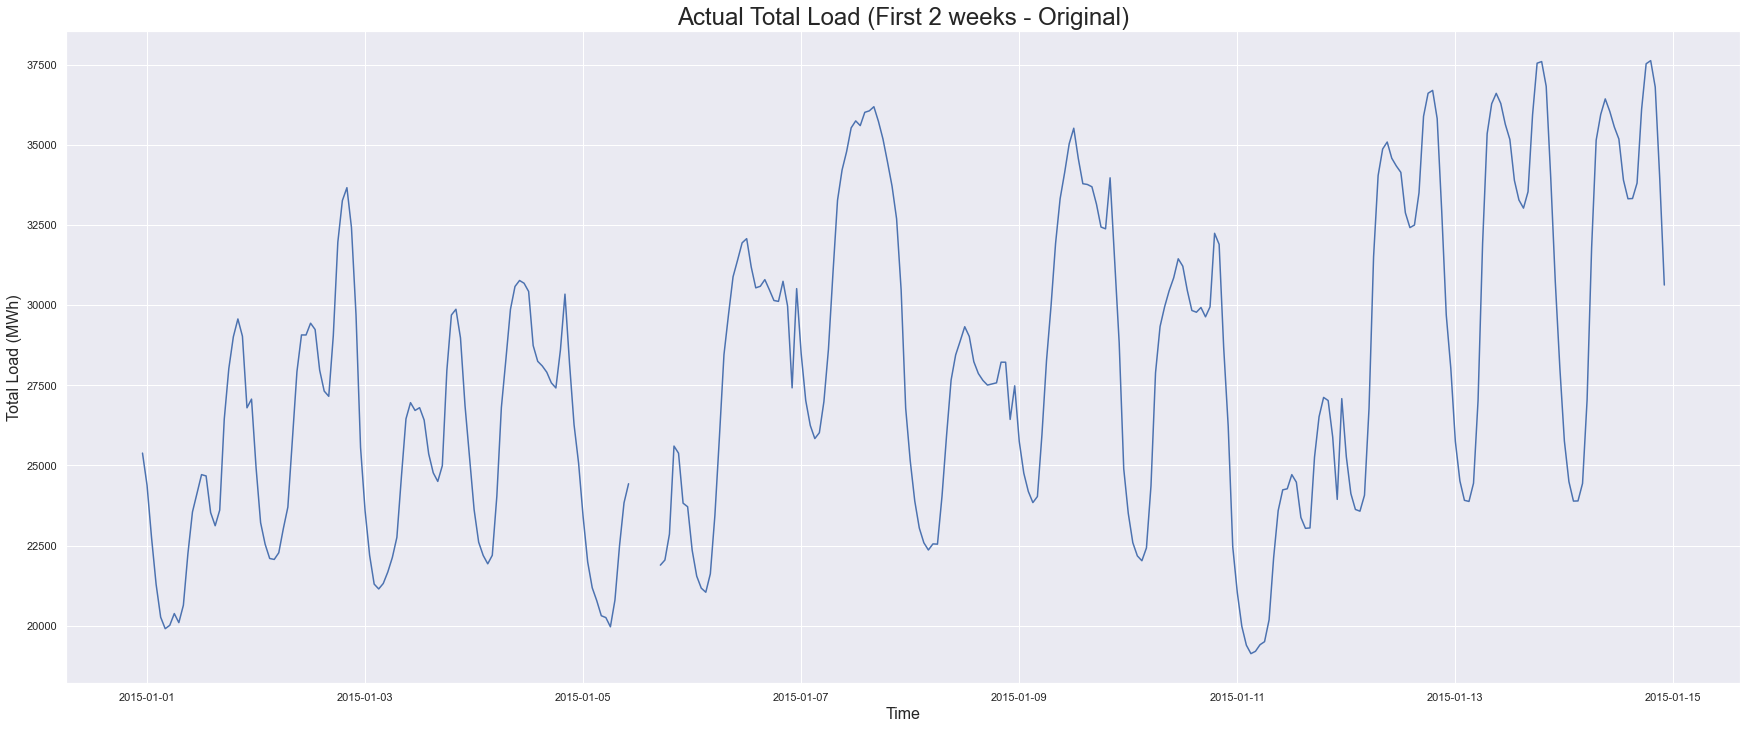

In [167]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

In [168]:
# Display the rows with null values

df_energy[df_energy.isnull().any(axis=1)].tail()

generation biomass  \
time                                            
2016-11-23 03:00:00+00:00                 NaN   
2017-11-14 11:00:00+00:00                 0.0   
2017-11-14 18:00:00+00:00                 0.0   
2018-06-11 16:00:00+00:00               331.0   
2018-07-11 07:00:00+00:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2016-11-23 03:00:00+00:00                                 900.0   
2017-11-14 11:00:00+00:00                                   0.0   
2017-11-14 18:00:00+00:00                                   0.0   
2018-06-11 16:00:00+00:00                                 506.0   
2018-07-11 07:00:00+00:00                                   NaN   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2016-11-23 03:00:00+00:00                 4838.0                       4547.0   
2017-11-14 11:00:00+00:00                10064.0                          0.0   
2017-11-14 18:00:00+00:00                12336.0                          0.0   
2018-06-11 16:00:00+00:00                 7538.0                       5360.0   
2018-07-11 07:00:00+00:00                    NaN                          NaN   

                           generation fossil oil  \
time                                               
2016-11-23 03:00:00+00:00                  269.0   
2017-11-14 11:00:00+00:00                    0.0   
2017-11-14 18:00:00+00:00                    0.0   
2018-06-11 16:00:00+00:00                  300.0   
2018-07-11 07:00:00+00:00                    NaN   

                           generation hydro pumped storage consumption  \
time                                                                     
2016-11-23 03:00:00+00:00                                       1413.0   
2017-11-14 11:00:00+00:00                                          0.0   
2017-11-14 18:00:00+00:00                                          0.0   
2018-06-11 16:00:00+00:00                                          1.0   
2018-07-11 07:00:00+00:00                                          NaN   

                           generation hydro run-of-river and poundage  \
time                                                                    
2016-11-23 03:00:00+00:00                                       795.0   
2017-11-14 11:00:00+00:00                                         0.0   
2017-11-14 18:00:00+00:00                                         0.0   
2018-06-11 16:00:00+00:00                                      1134.0   
2018-07-11 07:00:00+00:00                                         NaN   

                           generation hydro water reservoir  \
time                                                          
2016-11-23 03:00:00+00:00                             435.0   
2017-11-14 11:00:00+00:00                               0.0   
2017-11-14 18:00:00+00:00                               0.0   
2018-06-11 16:00:00+00:00                            4258.0   
2018-07-11 07:00:00+00:00                               NaN   

                           generation nuclear  generation other  \
time                                                              
2016-11-23 03:00:00+00:00              5040.0              60.0   
2017-11-14 11:00:00+00:00                 0.0               0.0   
2017-11-14 18:00:00+00:00                 0.0               0.0   
2018-06-11 16:00:00+00:00              5856.0              52.0   
2018-07-11 07:00:00+00:00                 NaN               NaN   

                           generation other renewable  generation solar  \
time                                                                      
2016-11-23 03:00:00+00:00                        85.0              15.0   
2017-11-14 11:00:00+00:00                         0.0               0.0   
2017-11-14 18:00:00+00:00            

In [169]:
# Fill null values using interpolation

df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

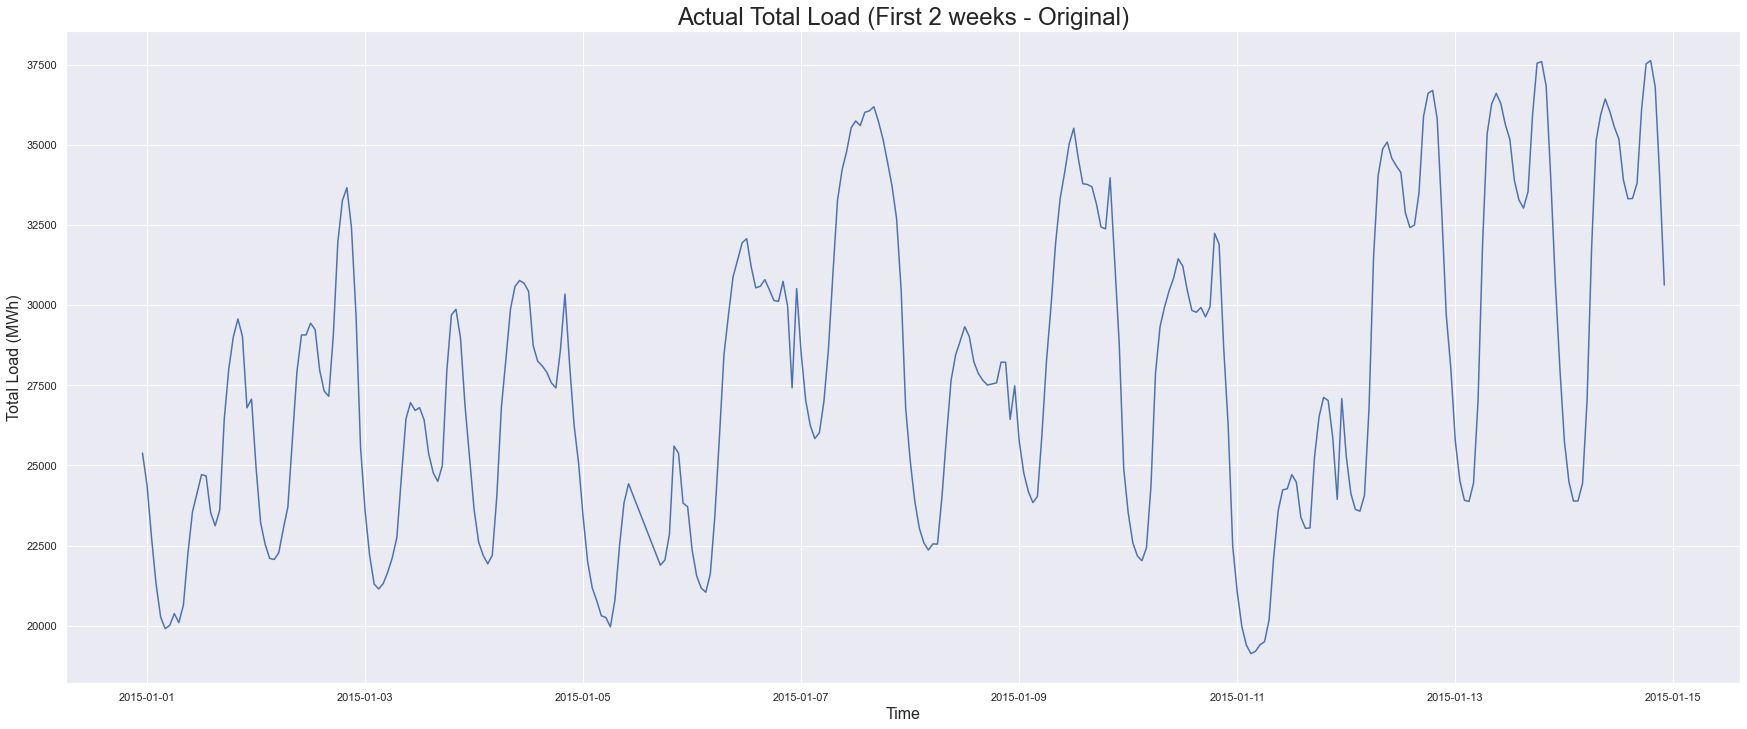

In [170]:
# Zoom into the plot of the hourly (actual) total load - now interpolated

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

In [171]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35064 non-null  float64
 1   generation fossil brown coal/lignite         35064 non-null  float64
 2   generation fossil gas                        35064 non-null  float64
 3   generation fossil hard coal                  35064 non-null  float64
 4   generation fossil oil                        35064 non-null  float64
 5   generation hydro pumped storage consumption  35064 non-null  float64
 6   generation hydro run-of-river and poundage   35064 non-null  float64
 7   generation hydro water reservoir             35064 non-null  float64
 8   generation nuclear                           35064 non-null  float64
 9   generation other         

In [172]:
df_weather.tail(5)

dt_iso city_name    temp  temp_min  temp_max  \
178391  2018-12-31 19:00:00+01:00   Seville  287.76    287.15    288.15   
178392  2018-12-31 20:00:00+01:00   Seville  285.76    285.15    286.15   
178393  2018-12-31 21:00:00+01:00   Seville  285.15    285.15    285.15   
178394  2018-12-31 22:00:00+01:00   Seville  284.15    284.15    284.15   
178395  2018-12-31 23:00:00+01:00   Seville  283.97    282.15    285.15   

        pressure  humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  \
178391      1028        54           3        30      0.0      0.0      0.0   
178392      1029        62           3        30      0.0      0.0      0.0   
178393      1028        58           4        50      0.0      0.0      0.0   
178394      1029        57           4        60      0.0      0.0      0.0   
178395      1029        70           3        50      0.0      0.0      0.0   

        clouds_all  weather_id weather_main weather_description weather_icon  
178391           0         800        clear        sky is clear          01n  
178392           0         800        clear        sky is clear          01n  
178393           0         800        clear        sky is clear          01n  
178394           0         800        clear        sky is clear          01n  
178395           0         800        clear        sky is clear          01n

In [173]:
df_weather.describe(include='all').T.round(2)

count unique                        top   freq  \
dt_iso                 178396  35064  2015-10-01 02:00:00+02:00     10   
city_name              178396      5                     Madrid  36267   
temp                 178396.0    NaN                        NaN    NaN   
temp_min             178396.0    NaN                        NaN    NaN   
temp_max             178396.0    NaN                        NaN    NaN   
pressure             178396.0    NaN                        NaN    NaN   
humidity             178396.0    NaN                        NaN    NaN   
wind_speed           178396.0    NaN                        NaN    NaN   
wind_deg             178396.0    NaN                        NaN    NaN   
rain_1h              178396.0    NaN                        NaN    NaN   
rain_3h              178396.0    NaN                        NaN    NaN   
snow_3h              178396.0    NaN                        NaN    NaN   
clouds_all           178396.0    NaN                        NaN    NaN   
weather_id           178396.0    NaN                        NaN    NaN   
weather_main           178396     12                      clear  82685   
weather_description    178396     43               sky is clear  82685   
weather_icon           178396     24                        01n  38541   

                           mean          std     min         25%     50%  \
dt_iso                      NaN          NaN     NaN         NaN     NaN   
city_name                   NaN          NaN     NaN         NaN     NaN   
temp                 289.618605     8.026199  262.24      283.67  289.15   
temp_min             288.330442     7.955491  262.24  282.483602  288.15   
temp_max             291.091267     8.612454  262.24      284.65  290.15   
pressure             1069.26074  5969.631893     0.0      1013.0  1018.0   
humidity              68.423457    21.902888     0.0        53.0    72.0   
wind_speed              2.47056      2.09591     0.0         1.0     2.0   
wind_deg              166.59119   116.611927     0.0        55.0   177.0   
rain_1h                0.075492     0.398847     0.0         0.0     0.0   
rain_3h                 0.00038     0.007288     0.0         0.0     0.0   
snow_3h                0.004763     0.222604     0.0         0.0     0.0   
clouds_all            25.073292    30.774129     0.0         0.0    20.0   
weather_id           759.831902   108.733223   200.0       800.0   800.0   
weather_main                NaN          NaN     NaN         NaN     NaN   
weather_description         NaN          NaN     NaN         NaN     NaN   
weather_icon                NaN          NaN     NaN         NaN     NaN   

                            75%        max  
dt_iso                      NaN        NaN  
city_name                   NaN        NaN  
temp                     295.15      315.6  
temp_min             293.730125     315.15  
temp_max                 297.15     321.15  
pressure                 1022.0  1008371.0  
humidity                   87.0      100.0  
wind_speed                  4.0      133.0  
wind_deg                  270.0      360.0  
rain_1h                     0.0       12.0  
rain_3h                     0.0      2.315  
snow_3h                     0.0       21.5  
clouds_all                 40.0      100.0  
weather_id                801.0      804.0  
weather_main                NaN        NaN  
weather_description         NaN        NaN  
weather_icon                NaN        NaN

Here, we can see that all columns of df_weather have the same number of rows; we still have to check what is the case for each city individually, though. We should note that the temperatures are in Kelvin. The most important thing to notice is that there are some problems and outliers. In particular:

- There is at least one outlier in the 'pressure' column as the maximum value is 1,008,371 hPa or approximately 100 MPa, which is roughly the pressure at the bottom of Mariana Trench about 11 km below ocean surface [2]. This cannot be the case here.

- There is at least one outlier in the 'wind_speed' column as the maximum value is 133 m/s. This measurement is close to the fastest wind speed ever recorded on Earth, caused by the 1999 Bridge Creek–Moore tornado [3], a F5 (the largest intensity of the Fujita scale) tornado [4]. A tornado of such intensity has not been recorded in Spain [5] and hopefully will not happen in the future as well.

- The 'rain_3h' column is supposed to provide information about the precipitation (i.e. rain) of the last 3 hours in mm. Since the 'rain_1h' column is supposed to provide the same information but about just the last hour, it would be logical to assume that its mean would be less than that of 'rain_3h'. However, this is not the case in the statistical description above. So, it would be a good idea to further examine those columns.

In [174]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [175]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [176]:
# Convert columns with int64 type values to float64 type
df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

# Convert dt_iso to datetime type, rename it and set it as index
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [177]:
# Display average weather features grouped by each city
mean_weather_by_city = df_weather.groupby('city_name').mean()
mean_weather_by_city

temp    temp_min    temp_max     pressure   humidity  \
city_name                                                                
 Barcelona  289.848248  288.594704  291.021987  1284.010486  73.994221   
Bilbao      286.378489  284.916661  288.036687  1017.567439  79.089455   
Madrid      288.061071  286.824877  289.155600  1011.838448  59.776932   
Seville     293.105431  291.184103  295.962431  1018.504711  64.140732   
Valencia    290.780780  290.222277  291.355025  1015.973794  65.145113   

            wind_speed    wind_deg   rain_1h   rain_3h   snow_3h  clouds_all  \
city_name                                                                      
 Barcelona    2.786588  187.188043  0.117079  0.000327  0.000000   23.229648   
Bilbao        1.957470  159.883536  0.123493  0.001034  0.023455   43.960697   
Madrid        2.441696  173.293159  0.055083  0.000129  0.000029   22.397028   
Seville       2.483787  151.757179  0.045392  0.000180  0.000000   14.748770   
Valencia      2.692815  160.753820  0.035924  0.000226  0.000154   20.820999   

            weather_id  
city_name               
 Barcelona  760.917465  
Bilbao      723.943228  
Madrid      762.260264  
Seville     771.409849  
Valencia    781.228283

In [178]:
# Find NaNs and duplicates in df_weather

print(f'There are {df_weather.isnull().values.sum()} missing values or NaNs in df_weather.')
temp_weather = df_weather.duplicated(keep='first').sum()
print(f'There are {temp_weather} duplicate rows in df_weather based on all columns.')

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather based on all columns.


In [179]:
# Display the number of rows in each dataframe

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


As we can see, the two dataframes (df_energy and df_weather) cannot be merged yet. There are many duplicates for every city in df_weather and we should drop them and see if their number of rows match. We do this by resetting the index, keeping only the first rows which have the same 'time' and 'city_name' values and then setting again 'time' as the index. For further research on the dataset, let us also create a second dataframe, df_weather_2 in which we do the same procedure, but keep only the last rows which have the same 'time' and 'city_name'.

In [180]:
# Create df_weather_2 and drop duplicate rows in df_weather

df_weather_2 = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], 
                                                        keep='last').set_index('time')

df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [181]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [182]:
df_weather['weather_icon'].unique()

array(['01n', '01d', '01', '02n', '02d', '02', '03', '04n', '04', '10n',
       '03n', '10', '04d', '03d', '10d', '50d', '09n', '11d', '11n',
       '09d', '50n', '13d', '13n', '13'], dtype=object)

In [183]:
df_weather['weather_description'].unique()

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [184]:
df_weather['weather_main'].unique()

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [185]:
df_weather['weather_id'].unique()

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])

We can see that in terms of qualitative description, the 'weather_main' column seems to contain the less detailed -or "poorest"- information, while 'weather_id' and 'weather_description' have more complex information and approximately the same number of unique values.

Nevertheless, it is also useful to check the consistency of the information in each column. Since our dataset contained duplicate rows and we utilized two different methods for cleaning it, a very good way to check the consistency of the data in these three columns would be to compare the two cleaned dataframes, df_weather and df_weather_2. In order to do this, we employ the R² ("R-squared" or "coefficient of determination") metric, after encoding 'weather_description' and 'weather_main' from strings to numerical labels.

In [186]:
# Define a function which will calculate R-squared score for the same column in two dataframes

def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("R-Squared score of {} is {}".format(column, r2.round(3)))

In [187]:
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')

R-Squared score of weather_description is 0.973
R-Squared score of weather_main is 0.963
R-Squared score of weather_id is 0.921


It seems that we have found incosistencies in our dataset. In particular, all three of the columns which contain qualitative info for the condition of the weather seem to contain a large part of the duplicates that we found earlier in df_weather. From the above R-squared scores, it seems that keeping and one-hot encoding 'weather_description' or 'weather_main' is the best idea to get the most out of information in the dataset. Note that the R² values of these two are not comparable because we have first encoded them; in order to actually calculate the similarity between two strings, we need to employ a different metric such as the Levenshtein distance, i.e. the number of edits required to transform string A to string B. In this case, even this metric would not be enough in order to make 'weather_main' and 'weather_description' comparable as the former contains only single words while the latter large phrases which describe the weather.

In [188]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id', 
                              'weather_description', 'weather_icon'], axis=1)

In [189]:
# Display the R-squared for all the columns in df_weather and df_weather_2

df_weather_cols = df_weather.columns.drop('city_name')

for col in df_weather_cols:
    encode_and_display_r2_score(df_weather, df_weather_2, col)

R-Squared score of temp is 1.0
R-Squared score of temp_min is 1.0
R-Squared score of temp_max is 1.0
R-Squared score of pressure is 1.0
R-Squared score of humidity is 1.0
R-Squared score of wind_speed is 1.0
R-Squared score of wind_deg is 1.0
R-Squared score of rain_1h is 1.0
R-Squared score of rain_3h is 1.0
R-Squared score of snow_3h is 1.0
R-Squared score of clouds_all is 1.0


In [190]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'], 
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


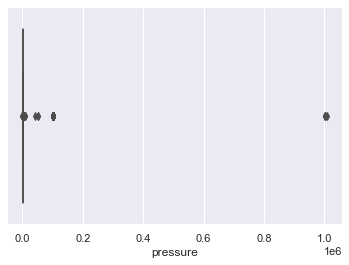

In [191]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_weather['pressure'])
plt.show()

In [192]:
# Replace outliers in 'pressure' with NaNs

df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

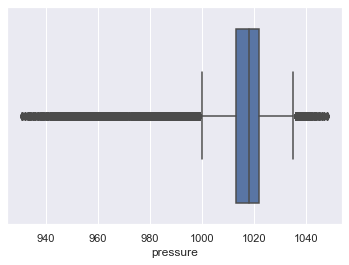

In [193]:
# Check for outliers in 'pressure' column again

sns.boxplot(x=df_weather['pressure'])
plt.show()

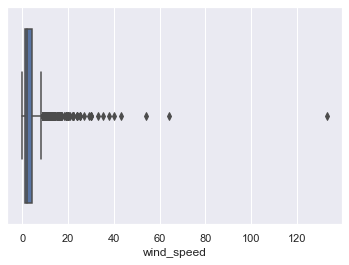

In [194]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [195]:
# Replace outliers in 'wind_speed' with NaNs

df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

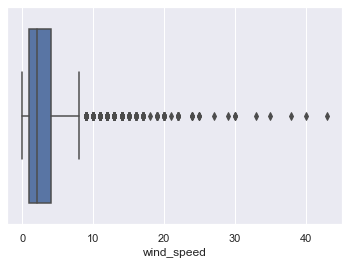

In [196]:
# Check for outliers in 'wind_speed' column again

sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [197]:
# Fill null values using interpolation

df_weather.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [198]:
# Split the df_weather into 5 dataframes (one for each city)

df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [199]:
# Merge all dataframes into the final dataframe

df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)
    
df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'rain_3h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao',
       'temp_max_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'rain_3h_Bilbao', 'snow_3h_Bilbao', 'clo

In [200]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_energy based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_energy based on all columns.


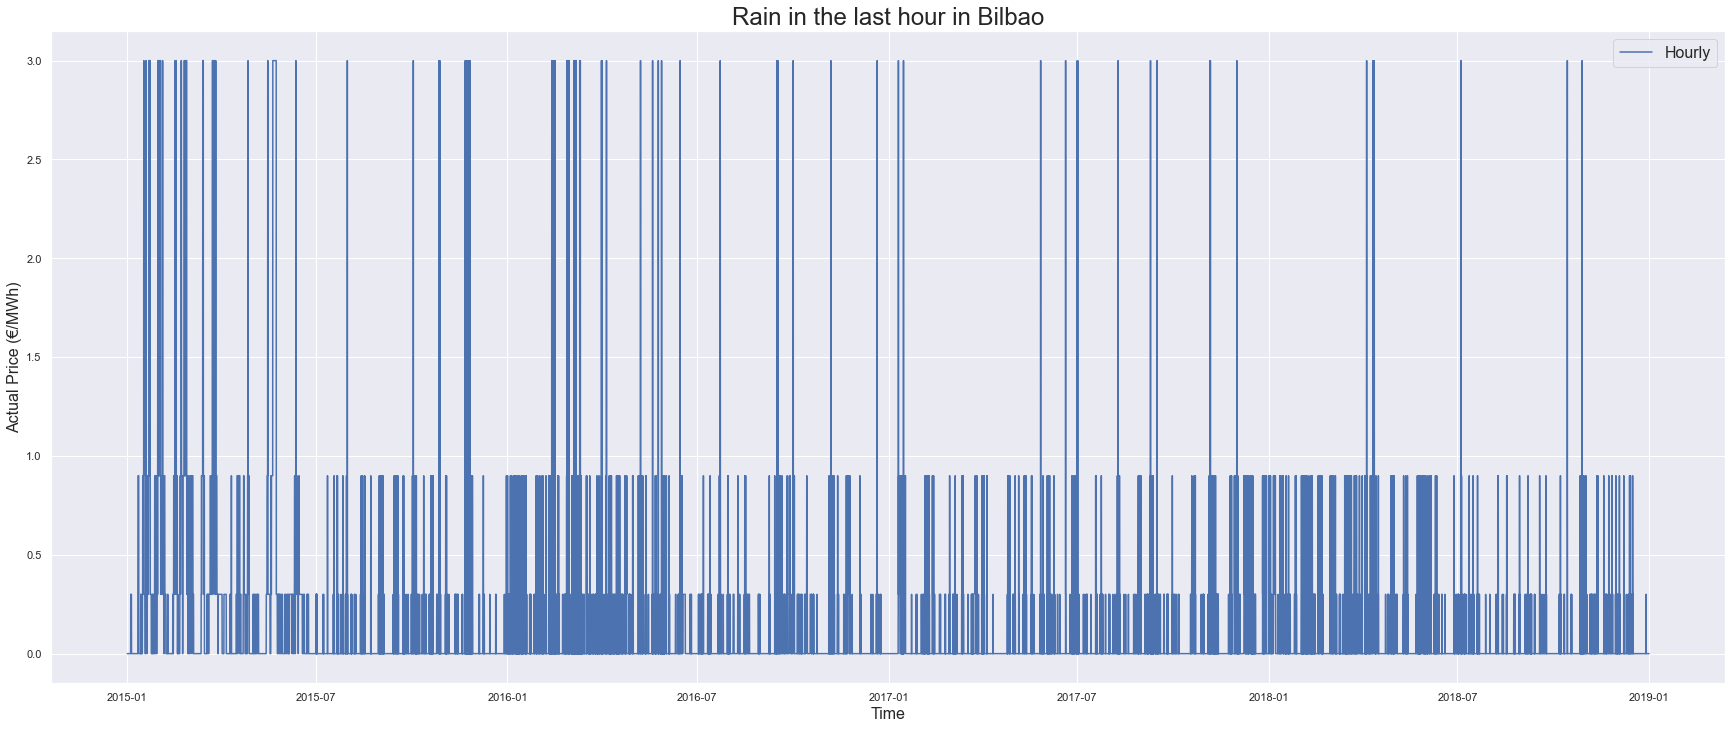

In [201]:
# Plot the 'rain_1h' for Bilbao

ax = plot_series(df_final, 'rain_1h_Bilbao', 
                 label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Rain in the last hour in Bilbao')
plt.show()

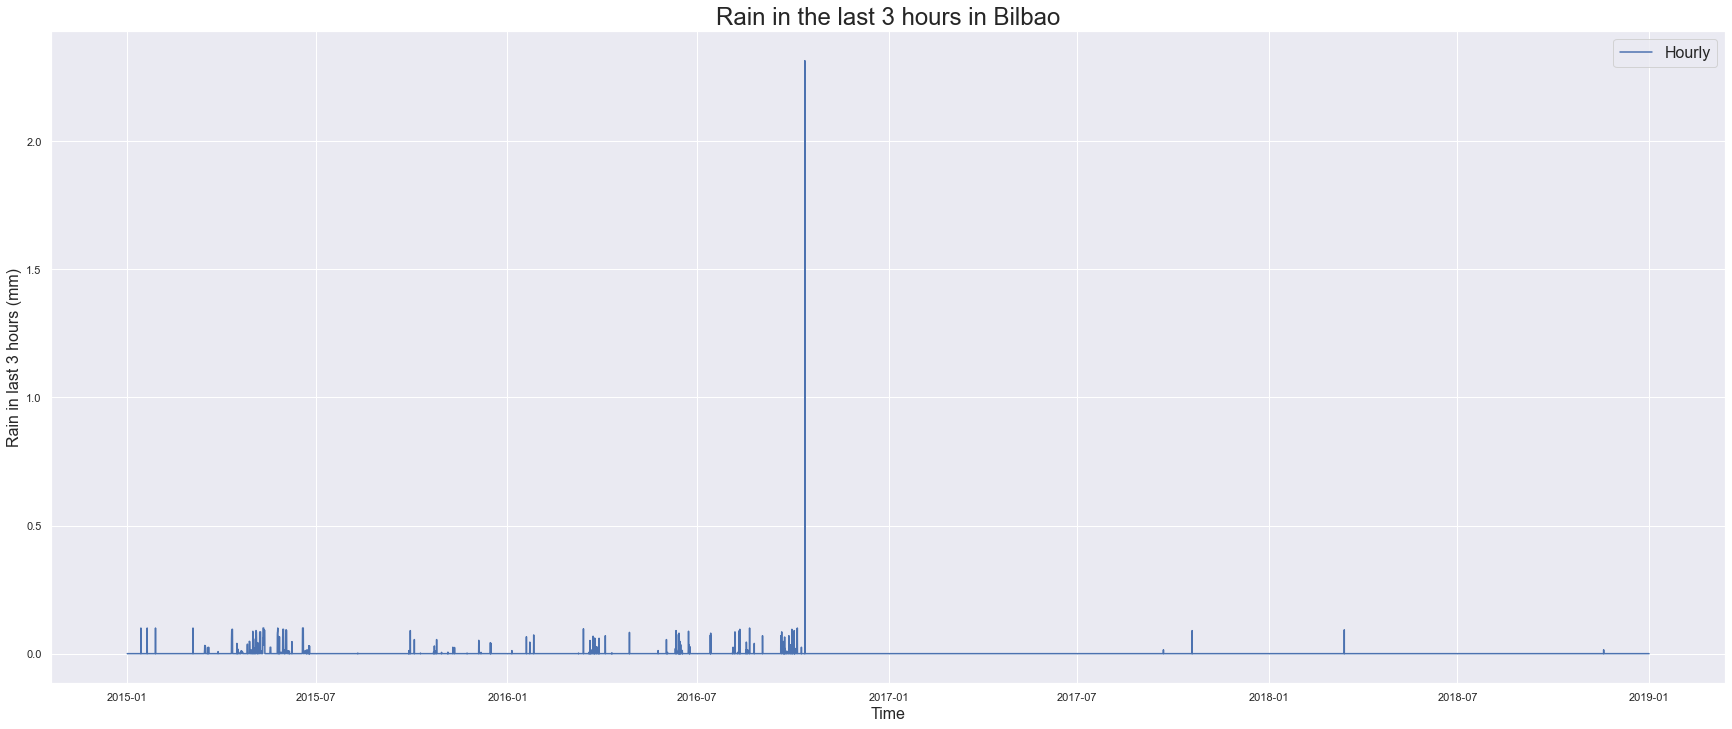

In [202]:
# Plot the 'rain_3h' for Bilbao

ax = plot_series(df_final, 'rain_3h_Bilbao', 
                 label='Hourly', ylabel='Rain in last 3 hours (mm)',
                 title='Rain in the last 3 hours in Bilbao')
plt.show()

From the two figures aboce, we can conclude that 'rain_3h' is an unreliable feature which will drop from the dataset.

In [203]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    df_final = df_final.drop(['rain_3h_{}'.format(city)], axis=1)

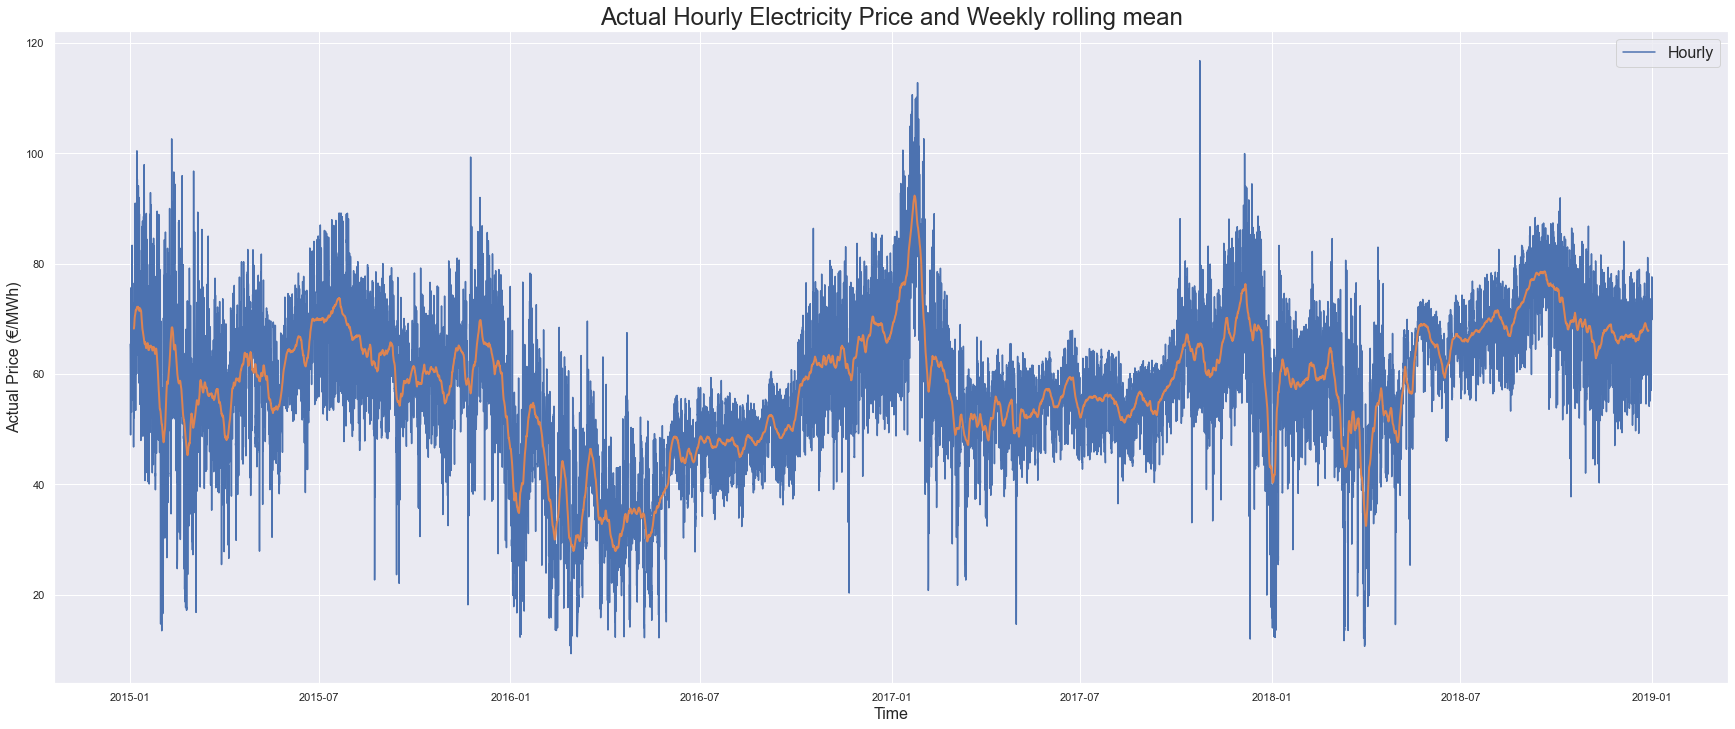

In [204]:
# Plot the hourly actual electricity price, along with the weekly rolling mean

rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

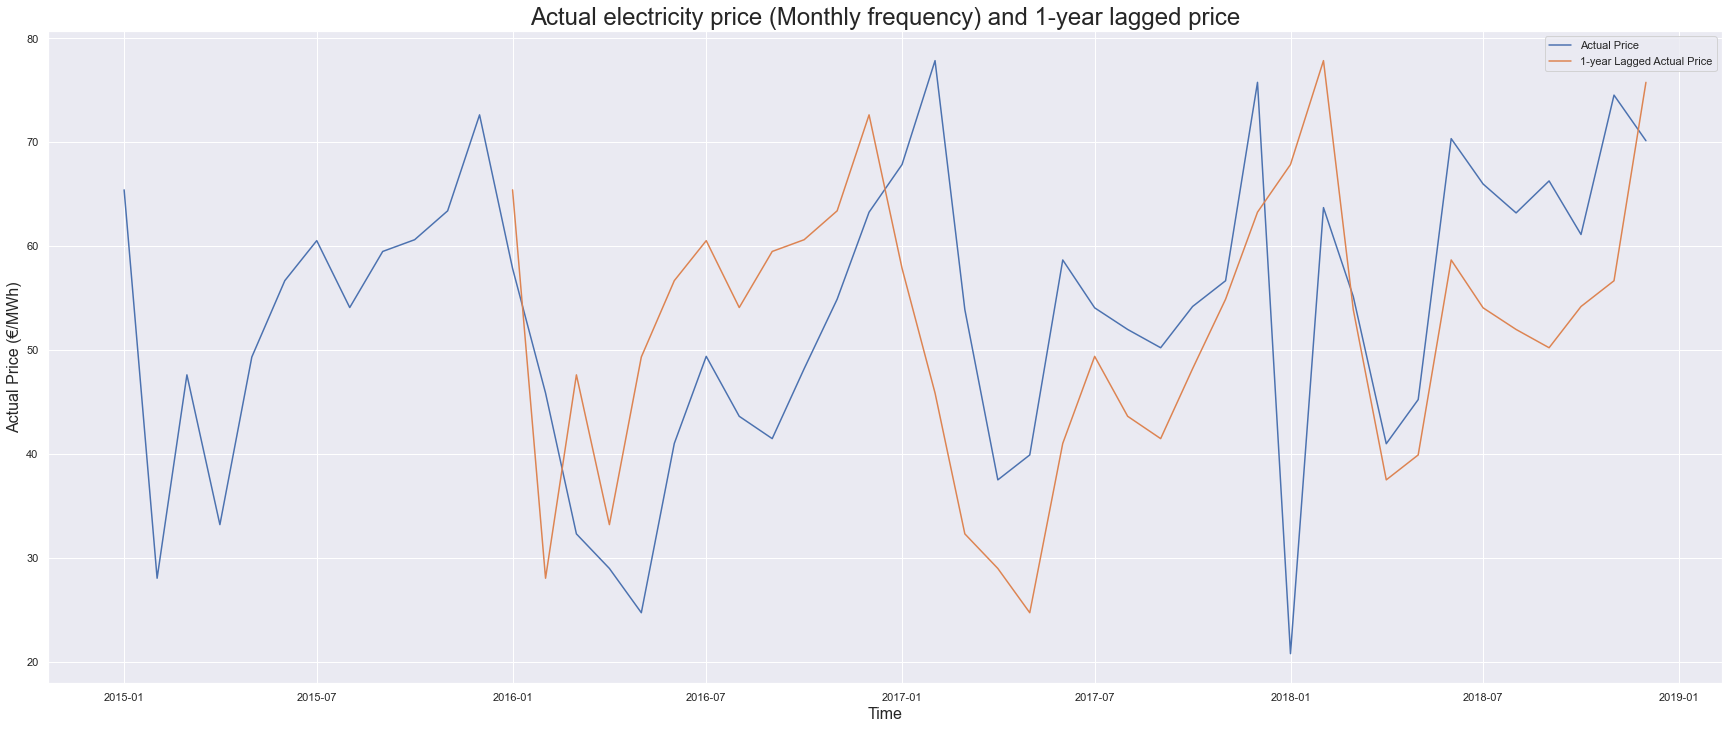

In [205]:
# Plot the electricity price (monthly frequence) along with its 1-year lagged series

monthly_price = df_final['price actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual electricity price (Monthly frequency) and 1-year lagged price')
shifted = df_final['price actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()

The figure above shows the (resampled) monthly frequency of the actual electricity price, along with its 1-year lagged monthly frequency. From this, we can see that there are indeed seasonal patterns at the monthly scale, as certain "spikes" in the time-series take place in exactly the same months. This means that it would be a good idea to create a new feature for the months. If the figure displayed the 1-year lagged actual energy price at hourly or weekly time scales, we would -of course- see no such seasonal patterns.

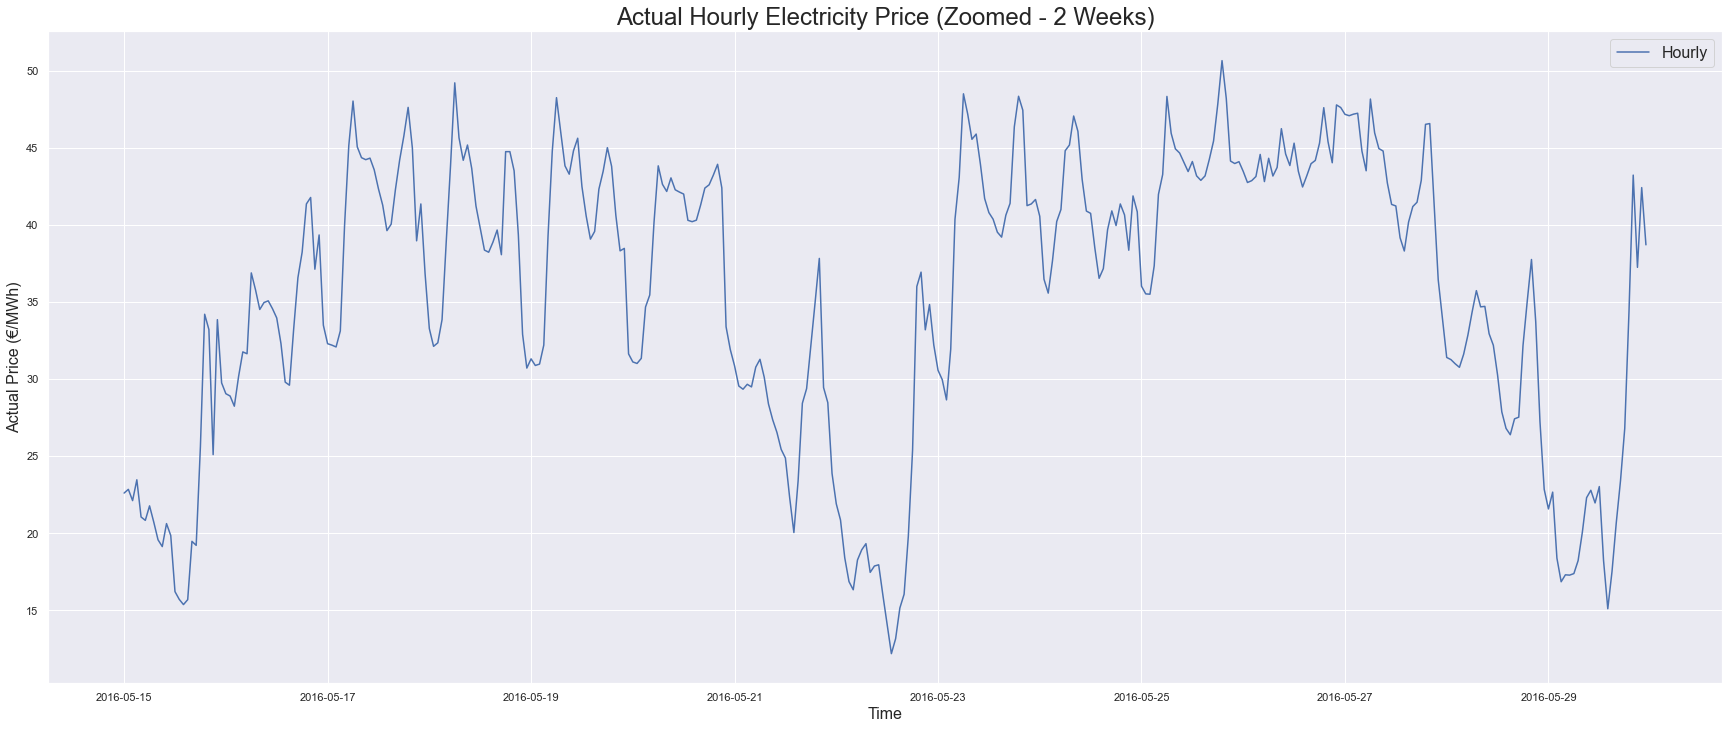

In [206]:
# Plot the actual electricity price at a daily/weekly scale

ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

In the figure above, we have plotted that actual hourly electricity price from 15/06/2016 (Sunday) at 00:00 up to 29/06/2016 (Sunday) at 23:00, i.e. two weeks of data. We can observe that there are many patterns and periodicities, such as:

- A periodicity from week to week, as the electricity price tends to be higher during business days and lower during weekends and especially during sundays.

- An intradyay periodicity, as the price is higher during the day and lower during the night.

- A periodicity within the business hours, as in some cases the electricity price drops for a few hours, which is probably due to "siesta", the traditional lunch break between 01:30PM and 04:30PM, as Spain does not strictly follow the 9AM-5PM business day.

Later on, we will make sure that we will generate features which contain these kinds of information.

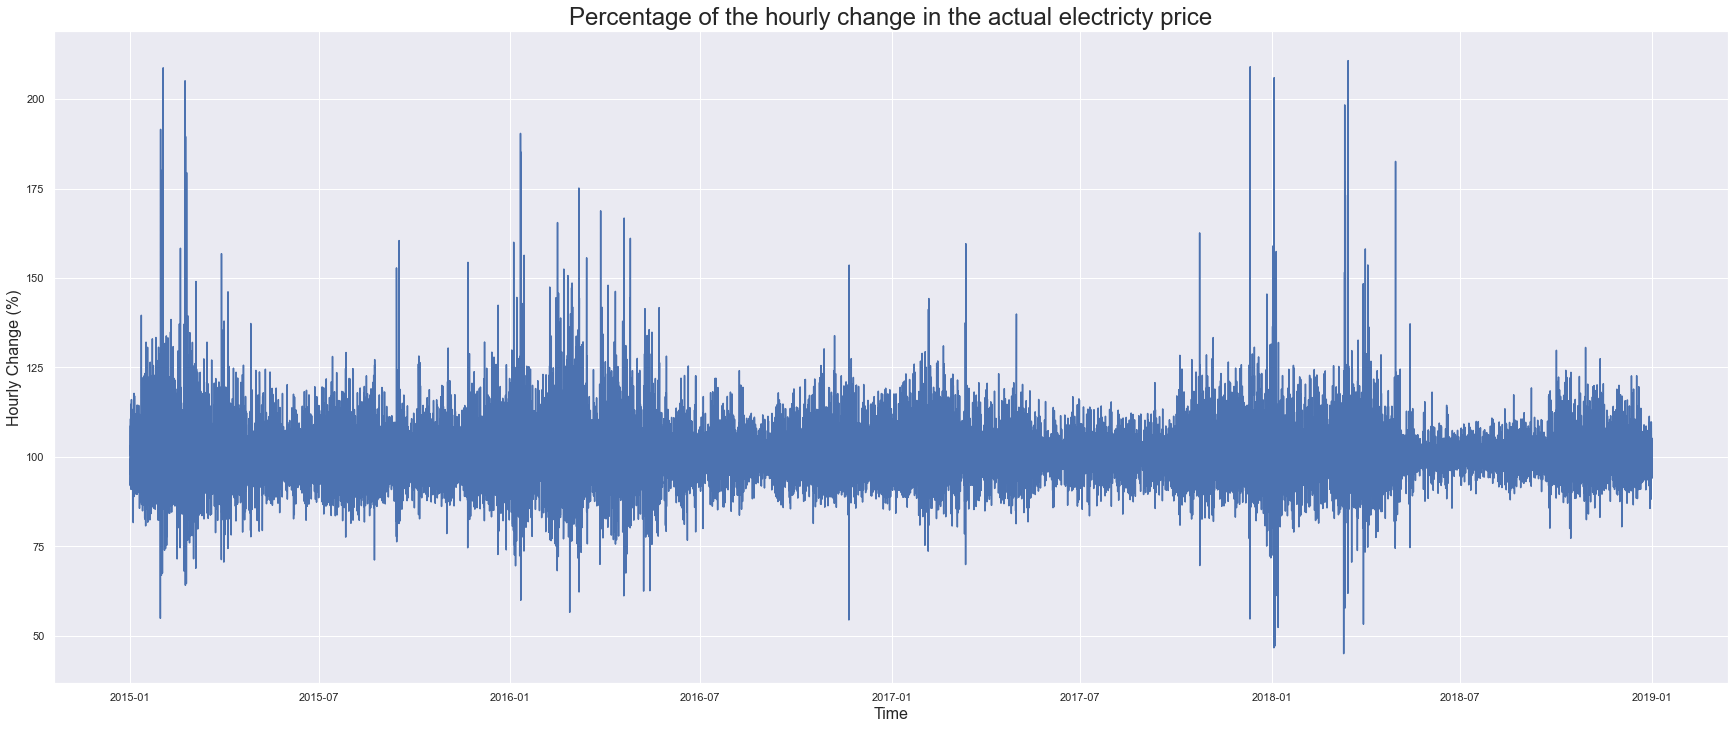

In [207]:
# Plot the percentage of the hourly change in the actual electricity price

change = df_energy['price actual'].div(df_energy['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the actual electricty price')
plt.show()

From the figure above, we can see that the change in the actual price from hour to hour is in most of the cases between -25% (actual price * 0.75) and +25% (actual price * 1.25). However, there are also very few outliers which show that the price gets halved (-50%) or doubled (+100%).

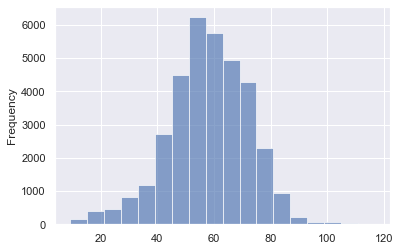

In [208]:
# Plot the histogram of the actual electricity price

ax = df_energy['price actual'].plot.hist(bins=18, alpha=0.65)

In the figure above, we can see that the actual energy price roughly follows a normal distribution and thus, could be standardized. However, we also have to make sure that the time series does not require any other kinds of transformations. More specifically, we will check whether the time series of energy price is stationary, after visualizing its decomposed component time-series.

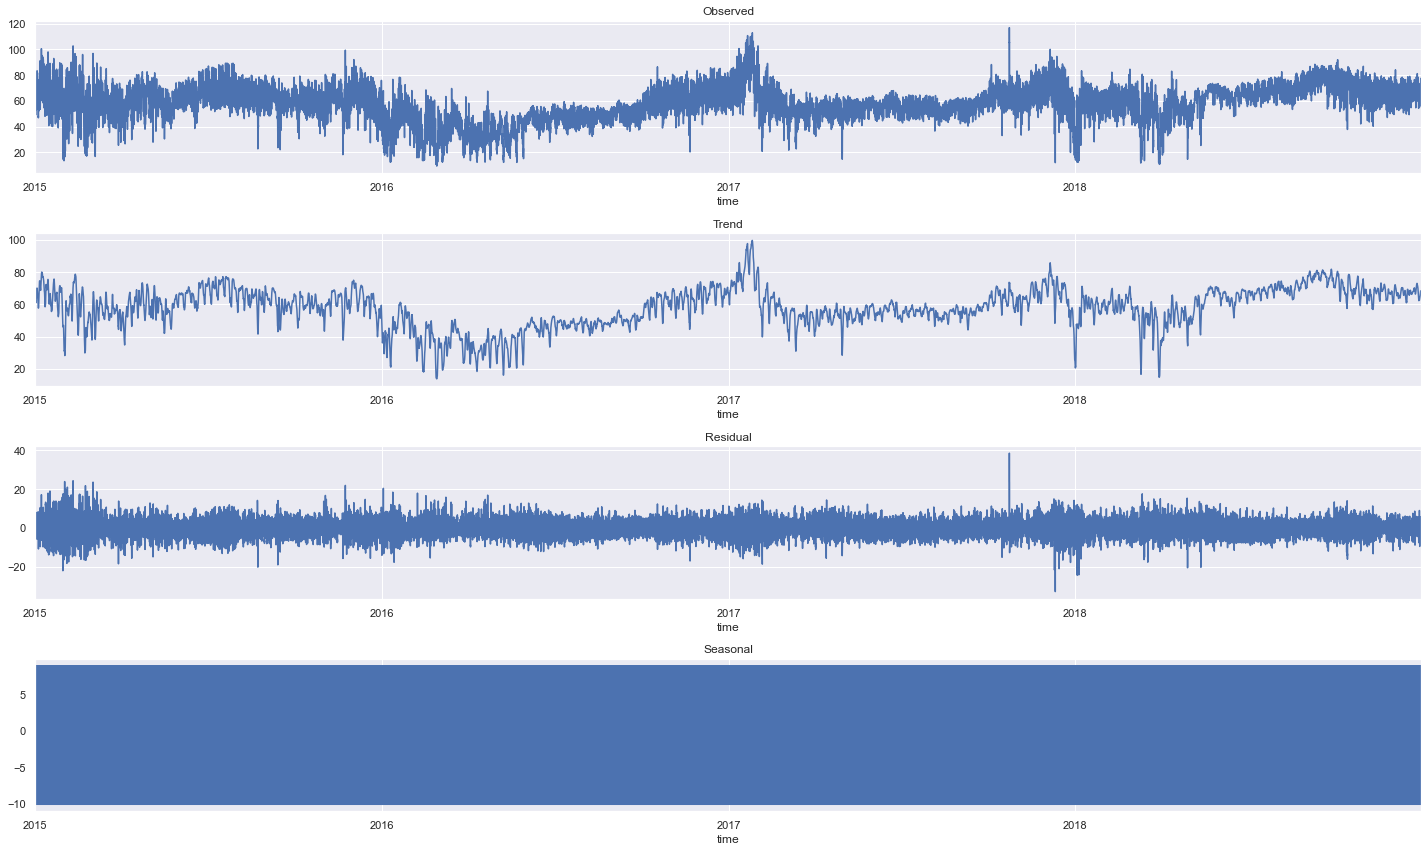

In [209]:
# Decompose the electricity price time series

res = sm.tsa.seasonal_decompose(df_energy['price actual'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

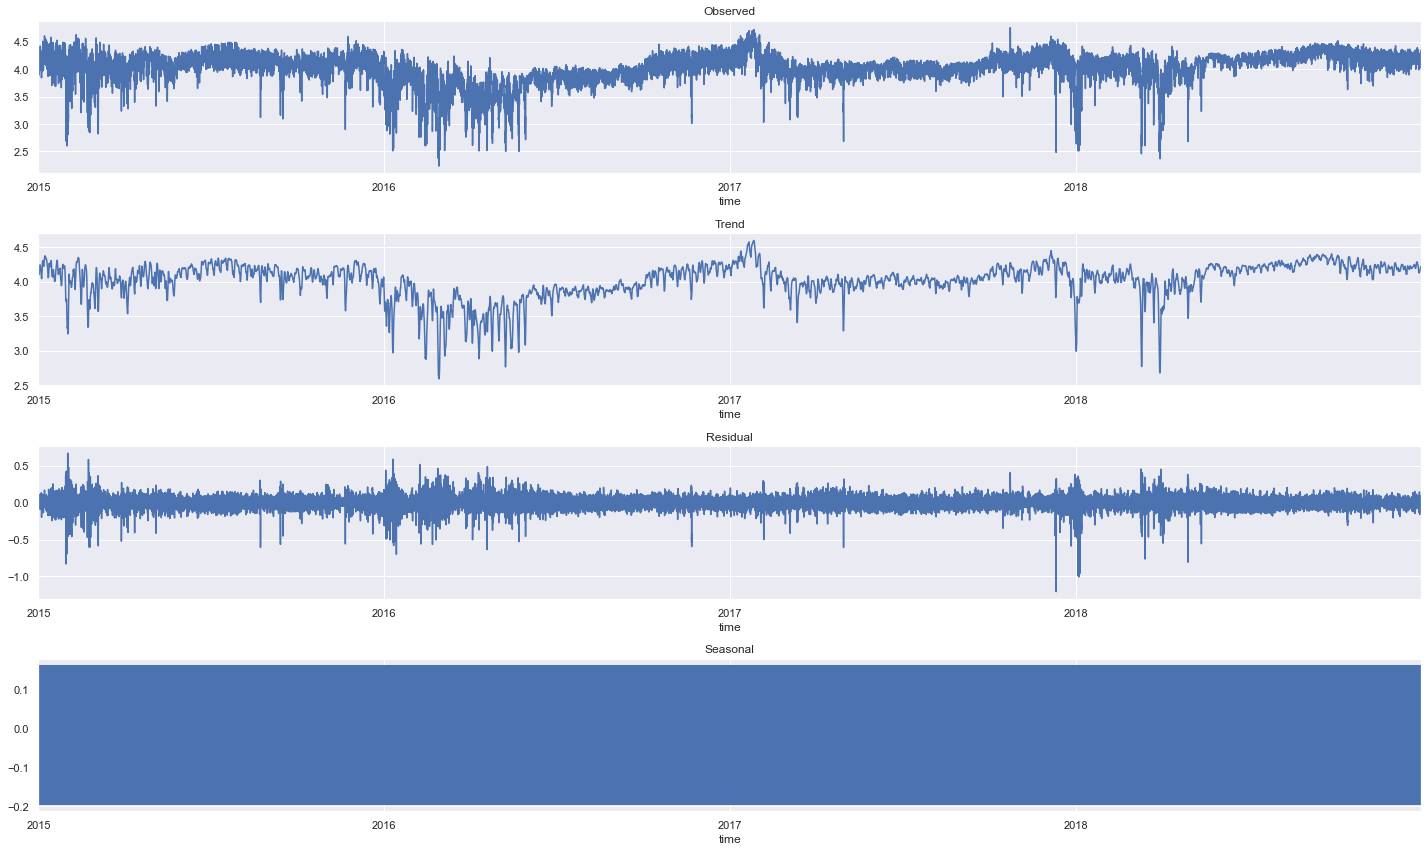

In [210]:
# Decompose the log electricity price time-series

res = sm.tsa.seasonal_decompose(np.log(df_energy['price actual']), model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

The Augmented Dickey-Fuller (ADF) test, a type of unit root test, determines how strongly a time series is defined by a trend. Its hypotheses are the following:

- Null Hypothesis  H0 : There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.

- Alternate Hypothesis  H1 : The time series has no unit root and is either stationary or can be made stationary using differencing.

In [211]:
y = df_final['price actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -9.147016
p-value: 0.000000
#Lags used: 50
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814


The ADF statistic (-9.147) is less than the critical value at 1% (-3.431) and thus, we can say that we reject the null hypothesis H0 with a significance level 1%, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, follows the opposite logic from Augmented Dickey-Fuller test and checks for stationarity. Its hypotheses are the following:

- Null Hypothesis  H0 : The time series is level, i.e. it is stationary around a constant.

- Alternate Hypothesis  H1 : There is a unit root in the time series and thus it not stationary.

In [212]:
kpss_test = kpss(y, regression='c')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 4.330034
p-value: 0.010000
#Lags used: 105
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


The KPSS statistic (7.957) is higher than the critical value at 1% (0.739) and thus, we can say that we cannot reject the null hypothesis H0 with a significance level 1%, meaning that the time series is stationary or stationary around a constant.

Both tests concluded that the electricity price time series is stationary, while it is also true that deep neural networks can handle such properties in a more forgiving way compared to ARIMA models.

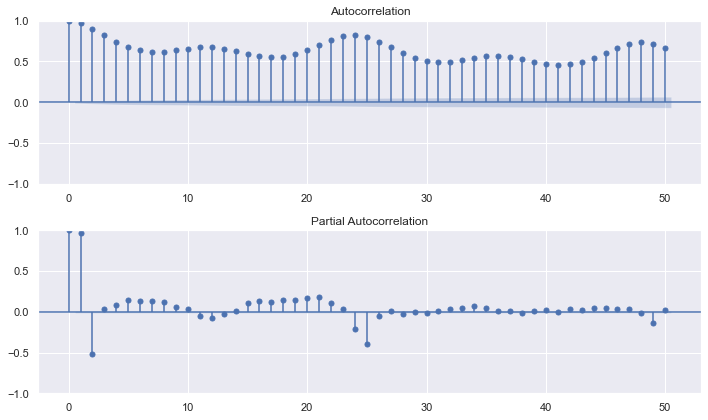

In [213]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_final['price actual'], lags=50, ax=ax1)
plot_pacf(df_final['price actual'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

The partial autocorrelation plot of the eletricity price time series shows that the direct relationship between an observation at a given hour (t) is strongest with the observations at t-1, t-2, t-24 and t-25 time-steps and diminishes afterwards. Thus, we are going to use the 25 previous values of each time series which will constitute a feature for our models.

Nevertheless, it would quite definitely be more beneficial if we only chose to use specific past values (observations at certain time-lags) of a given feature, based on the cross-correlation between the electricity price and each one of the features in the dataset. For example, below we can see the cross-correlation between the electricity price and the total load. We see that there are many time-lags with a correlation which is close to zero and could be ommited.

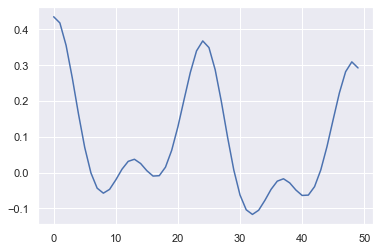

In [214]:
cross_corr = ccf(df_final['total load actual'], df_final['price actual'])
plt.plot(cross_corr[0:50])
plt.show()


For simplicity, we will just work with the correlations between the electricity price and the other features at each given hour.

In [215]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_final.corr(method='pearson')
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Barcelona                             0.249177
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
pressure_Valencia                              0.109812
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0

From the above, we can already see some very interesting correlations among the energy price that we want to predict and the rest of the features. For example, the total energy load and the amount of energy generated from sources related to fossil fuels, is positively correlated with the electricity price. In contrast, the wind speed in almost every city and the amount of storage energy cosumed through hydroelectric pumping is negatively correlated with the energy price. We will go ahead and drop the 'snow_3h_Barcelona' and 'snow_3h_Seville' which give NaNs in their correlations with the electricity actual price.

In [216]:
df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)

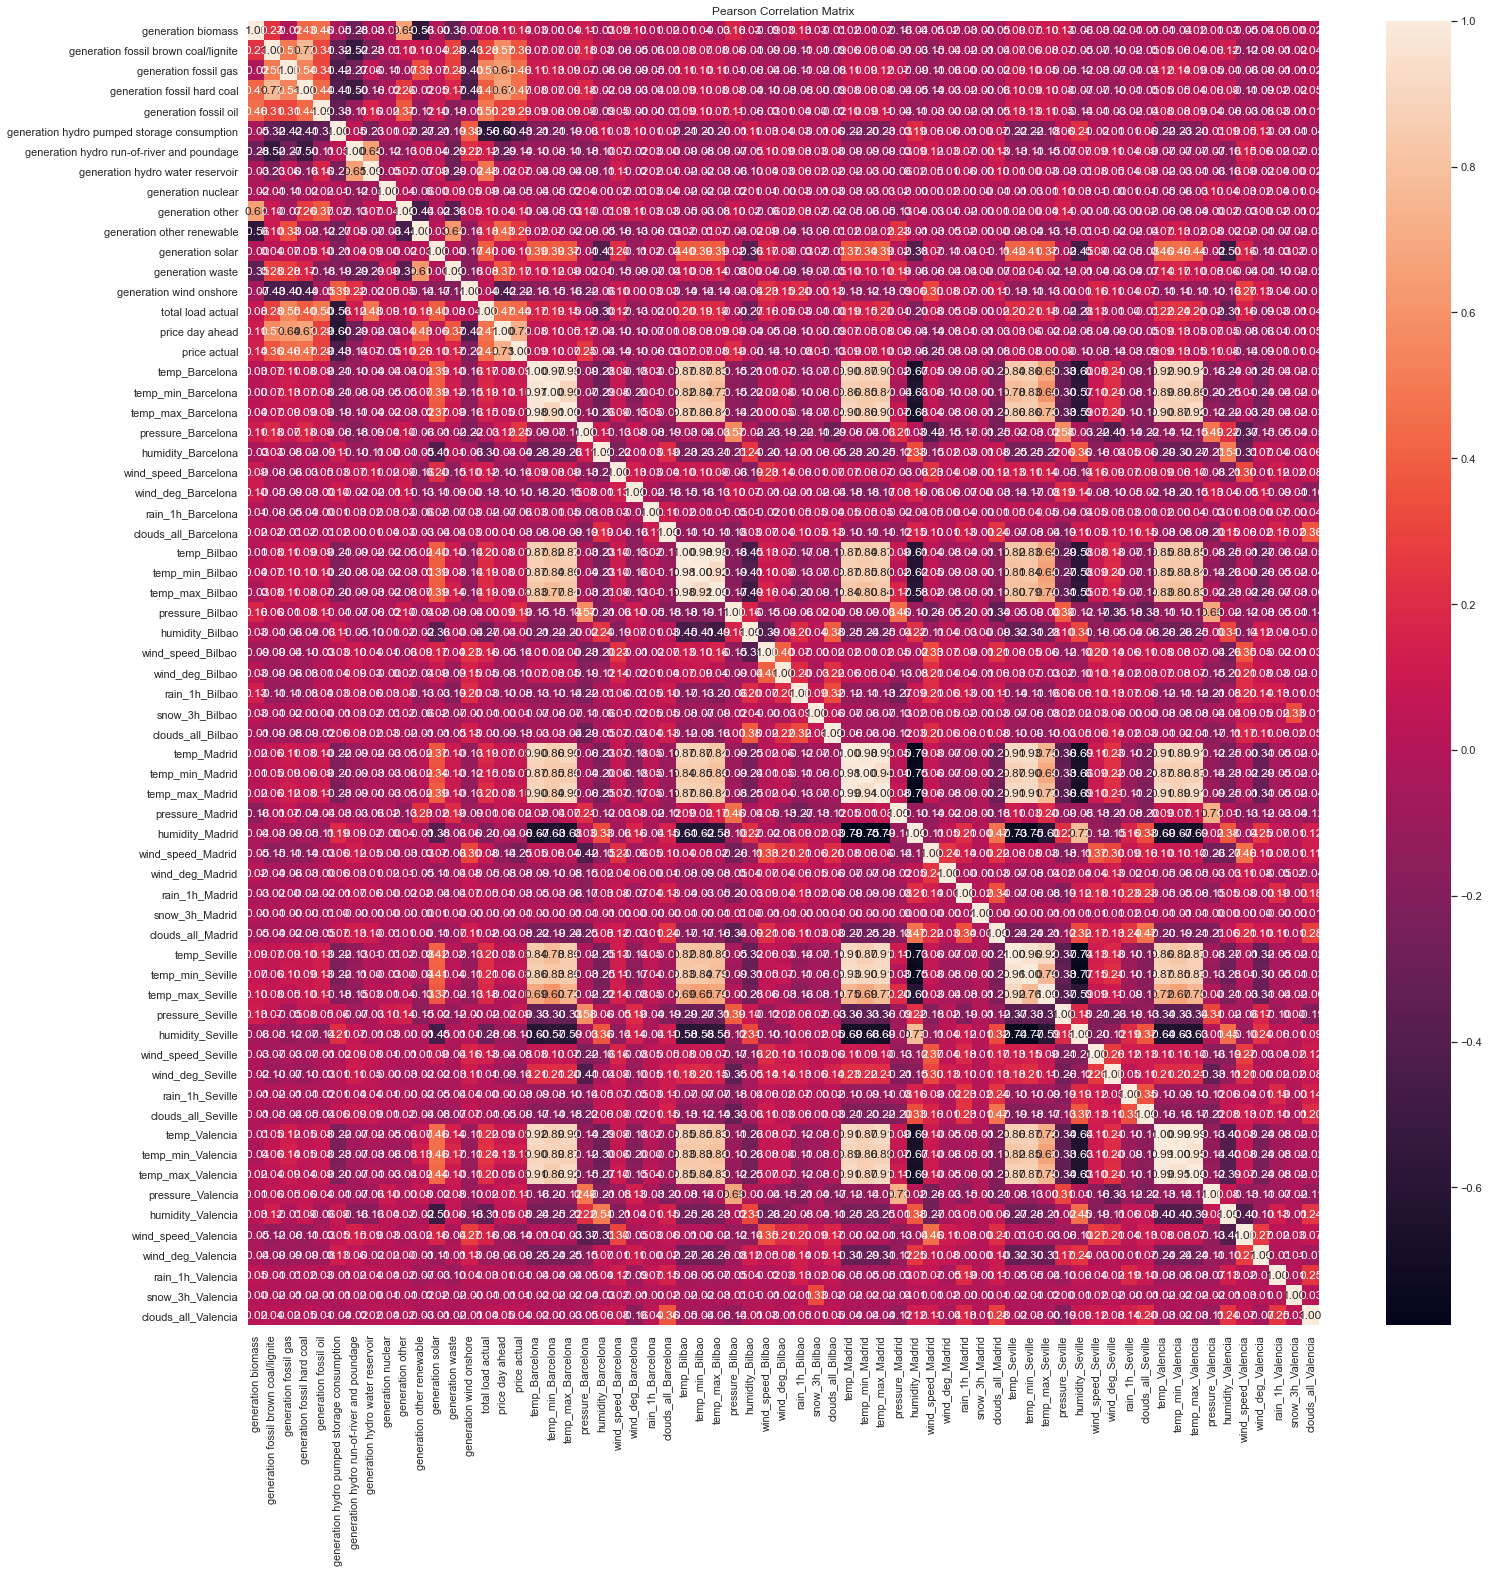

In [217]:
# Plot Pearson correlation matrix

correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

While we cannot make a lot out of the above correlation matrix, we can observe that there quite a lot of features that are highly correlated with each other.

In [218]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831
temp_Barcelona                        temp_min_Barcelona                      0.970264
                                      temp_max_Barcelona                      0.976904
                                      temp_Bilbao                             0.866727
                                      temp_min_Bilbao                         0.867970
                                      temp_max_Bilbao                         0.828347
                                      temp_Madrid                             0.903996
                                      temp_min_Madrid                         0.874548
                                      temp_max_Madrid                         0.899010
                                      temp_Seville                            0.841910
                                      temp_

What we can observe, is that apart from the amount of energy generated by fossil brown coal/lignit and hard coal, the most correlated features have to do with the temperatures among the different cities, as well the "secondary" information we have about the temperature of each individual city (i.e. the minimunm and maximum temperature).

In [219]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

A very useful feature that we will generate, has to do with the business hours, i.e. whether businesses are open or not in a given hour. However, there is a certain peculiarity in Spain as the 9AM-5PM working day is not generally followed by all types of businesses, due to a lunch break (known as "siesta") in between. The most usual business hours are from Monday-Saturday, from 9:30AM-1:30PM and then again from 4:30PM-8PM.

Therefore, the value of the 'business hour' will be equal to '2' if the given hour is within the business hours, equal to '1' if the given hour is within the "siesta" in between and equal to '0' for all other given hours.

In [220]:
# Generate 'business hour' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

However, we have generated the 'business hour' feature in such a way which also includes weekends, on which fewer -or different types of- businesses are open. Thus, it is useful to also generate another feature, 'weekend', which will distuingish weekdays and weekends, as well as make a distinction between Saturdays and Sundays.

In particular, for a particular given hour, the value of 'weekend' will be equal to '0', if the hours is in a weekday, equal to '1' if the hour is in a Saturday and equal to '2' if the hour is in a Sunday.

In [221]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In order to reduce the dimensionality and potentially acquire a new kind of information, for every given hour, we will subtract the minimum temperature ('temp_min') from the maximum temperature ('temp_max') for each city and we will name that feature 'temprange{name of city}'.

In [222]:
# Generate 'temp_range' for each city

cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for i in range(len(df_final)):
    position = df_final.index[i]
    for city in cities:
        temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
        df_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)

After seeing that there is a high correlation among the temperatures of the different cities, we will also try creating a weighted temperature features by taking into account each city's population [7].

- Madrid: 6,155,116
- Barcelona: 5,179,243
- Valencia: 1,645,342
- Seville: 1,305,342
- Bilbao: 987,000

In [223]:
# Calculate the weight of every city

total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000

weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop

In [224]:
cities_weights = {'Madrid': weight_Madrid, 
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}

In [225]:
# Generate 'temp_weighted' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    temp_weighted = 0
    for city in cities:
        temp = df_final.loc[position, 'temp_{}'.format(city)]
        temp_weighted += temp * cities_weights.get('{}'.format(city))
    df_final.loc[position, 'temp_weighted'] = temp_weighted

We will also generate a new feature which aggregates both energy sources which are related to coal and are highly correlated (0.7688).

In [226]:
df_final['generation coal all'] = df_final['generation fossil hard coal'] + df_final['generation fossil brown coal/lignite']

### Feature Selection

In [227]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [228]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [229]:
print(f"training set is {(train_end_idx/test_end_idx)*100} % of total")
print("----------------------------------------")
print(f"validation set is {((cv_end_idx - train_end_idx)/test_end_idx)*100} % of total")

training set is 77.13894592744695 % of total
----------------------------------------
validation set is 11.430527036276523 % of total


In [230]:
X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)

In [231]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [232]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [233]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

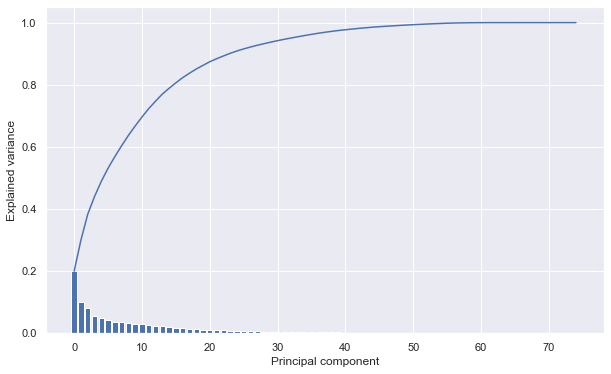

In [234]:
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [235]:
pca = PCA(n_components=0.80) #Originally .80
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)
print(X_pca.shape)

(35064, 16)


In [236]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

In [237]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)

X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [238]:
batch_size = 32
buffer_size = 1000

In [239]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [240]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=30)

In [241]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

### Electricity price forecasting

In [242]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses - only after 5 steps so initial drop doesnt obscure real curves
    
    train_rmse = history.history['root_mean_squared_error'][5:]
    val_rmse = history.history['val_root_mean_squared_error'][5:]
    
    train_loss = history.history['loss'][5:]
    val_loss = history.history['val_loss'][5:]
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#from sklearn.metrics import
def MAPE(y_true, y_pred):
    mape = np.mean((np.abs((y_true, y_pred)/y_true))*100)
    return mape


perf_dict = dict()

def add_to_perf_dict(model, y_true, y_pred):
    perf_dict[f'{model}'] = {
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': mean_squared_error(y_true, y_pred, squared=False),
        'mae': mean_absolute_error(y_true, y_pred),
        'mape': MAPE(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }
    return pd.DataFrame(perf_dict).T

#### XGBoost

In [243]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [244]:
param = {'eta': 0.03, 'max_depth': 180, 
         'subsample': 1.0, 'colsample_bytree': 0.95, 
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:squarederror', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}
         
# previously used re:linaer
dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)
eval_list = [(dtrain, 'train'), (dval, 'eval')]
#xgb.train()
xgb_model = xgb.train(param, dtrain, 500, evals=eval_list, early_stopping_rounds=10)

[17:11:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.14414	eval-rmse:0.11701
[1]	train-rmse:0.14003	eval-rmse:0.11373
[2]	train-rmse:0.13605	eval-rmse:0.11051
[3]	train-rmse:0.13220	eval-rmse:0.10743
[4]	train-rmse:0.12846	eval-rmse:0.10441
[5]	train-rmse:0.12485	eval-rmse:0.10148
[6]	train-rmse:0.12134	eval-rmse:0.09866
[7]	train-rmse:0.11795	eval-rmse:0.09594
[8]	train-rmse:0.11466	eval-rmse:0.09332
[9]	train-rmse:0.11148	eval-rmse:0.09076
[10]	train-rmse:0.10840	eval-rmse:0.08832
[11]	train-rmse:0.10542	eval-rmse:0.08591
[12]	train-rmse:0.10252	eval-rmse:0.08358
[13]	train-rmse:0.09972	eval-rmse:0.08134
[14]	tr

In [245]:
import sklearn
print(sklearn.__version__)

0.23.2


In [246]:
#from sklearn. metrics import mean_absolute_error, mean_squared_error, r2_score

#from sklearn.utils import check_arrays
#def mean_absolute_percentage_error(y_true, y_pred): 
#    y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

#    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#perf_dict = dict()

In [247]:
forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

#rmse_xgb = sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
#print('RMSE of hour-ahead electricity price XGBoost forecast: {}'.format(round(rmse_xgb, 3)))

add_to_perf_dict('xbg', y_test_inv, xgb_forecast_inv)

mae       mape       mse        r2      rmse
xbg  1.653383  99.853164  4.910046  0.928144  2.215862

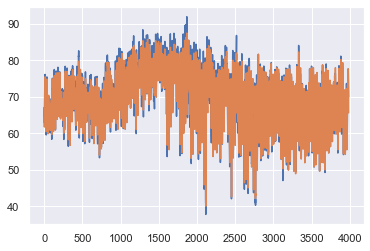

In [248]:
plt.plot(y_test_inv)
plt.plot(xgb_forecast_inv)

In [249]:
# Plot the hourly actual electricity price, along with the weekly rolling mean



#### LSTM

In [250]:
input_shape[1]

17

In [251]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Dropout(0.3),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.3),
    Dense(1) #input_shape[1] for multi-output
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [252]:
history = multivariate_lstm.fit(train, epochs=500,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/500
845/845 [==============================] - 38s 43ms/step - loss: 0.0913 - root_mean_squared_error: 0.3021 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0862
Epoch 2/500
845/845 [==============================] - 39s 46ms/step - loss: 0.0115 - root_mean_squared_error: 0.1074 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 3/500
845/845 [==============================] - 35s 42ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879
Epoch 4/500
845/845 [==============================] - 37s 44ms/step - loss: 0.0056 - root_mean_squared_error: 0.0748 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 5/500
845/845 [==============================] - 36s 43ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0633
Epoch 6/500
845/845 [==============================] - 36s 42ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_l

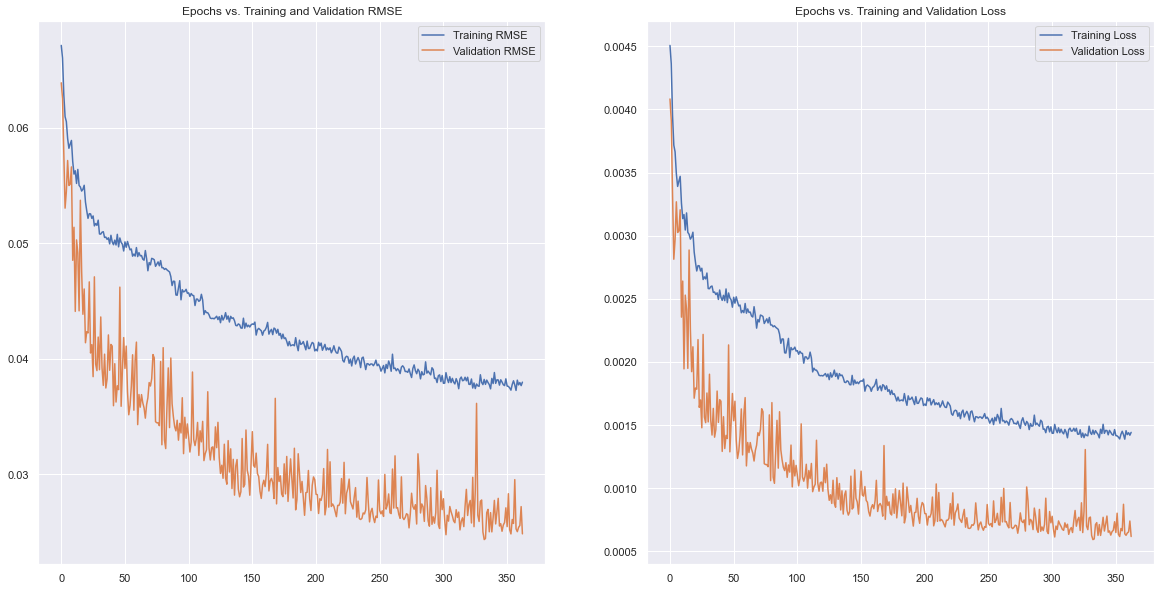

In [253]:
plot_model_rmse_and_loss(history)

In [254]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

#rmse_lstm = sqrt(mean_squared_error(y_test_inv, lstm_forecast[:,-1]))
#print('RMSE of hour-ahead electricity price LSTM forecast: {}'.format(round(rmse_lstm, 3)))

add_to_perf_dict('lstm', y_test_inv, lstm_forecast)

125/125 [==============================] - 2s 15ms/step


mse      rmse       mae       mape        r2
xbg   4.910046  2.215862  1.653383  99.853164  0.928144
lstm  5.406305  2.325146  1.752659  99.568938  0.920881

Does this give okay predictions for all variables? (so we could feed them forward for the specificed forecast hoprizon)

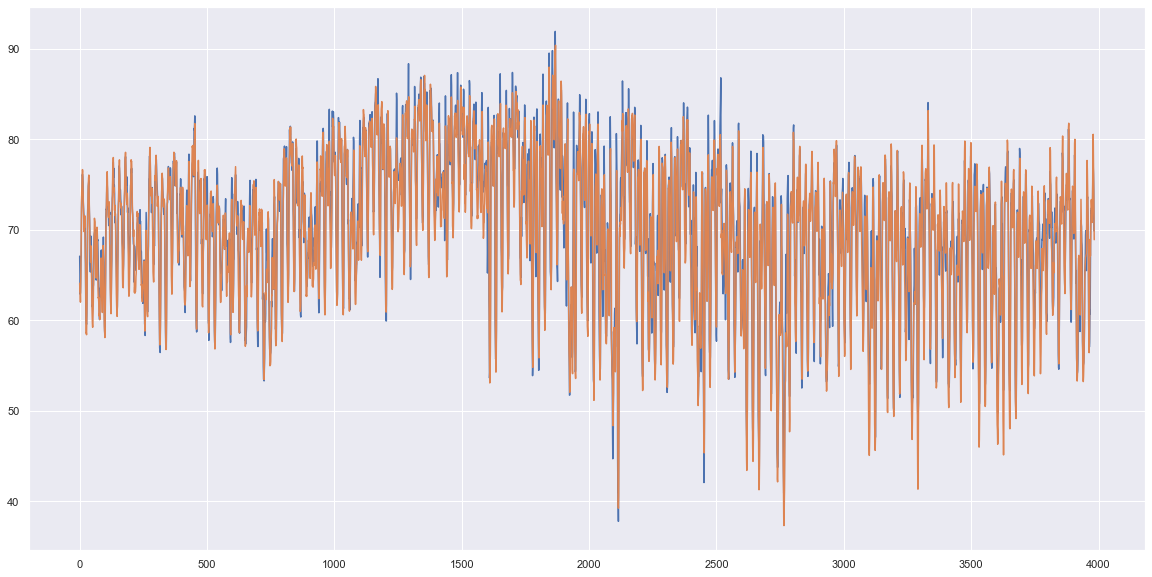

In [255]:
plt.figure(figsize=(20,10))
plt.plot(y_test_inv)
plt.plot(lstm_forecast)#, alpha=0.5)

#### Stacked LSTM

In [256]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, 
         return_sequences=True),
    Dropout(0.4),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [257]:
history = multivariate_stacked_lstm.fit(train, epochs=500,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/500
845/845 [==============================] - 212s 246ms/step - loss: 0.0203 - root_mean_squared_error: 0.1333 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889
Epoch 2/500
845/845 [==============================] - 187s 222ms/step - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0636
Epoch 3/500
845/845 [==============================] - 189s 224ms/step - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628
Epoch 4/500
845/845 [==============================] - 185s 219ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0527
Epoch 5/500
845/845 [==============================] - 183s 217ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0536
Epoch 6/500
845/845 [==============================] - 187s 221ms/step - loss: 0.0019 - root_mean_squared_error: 0.

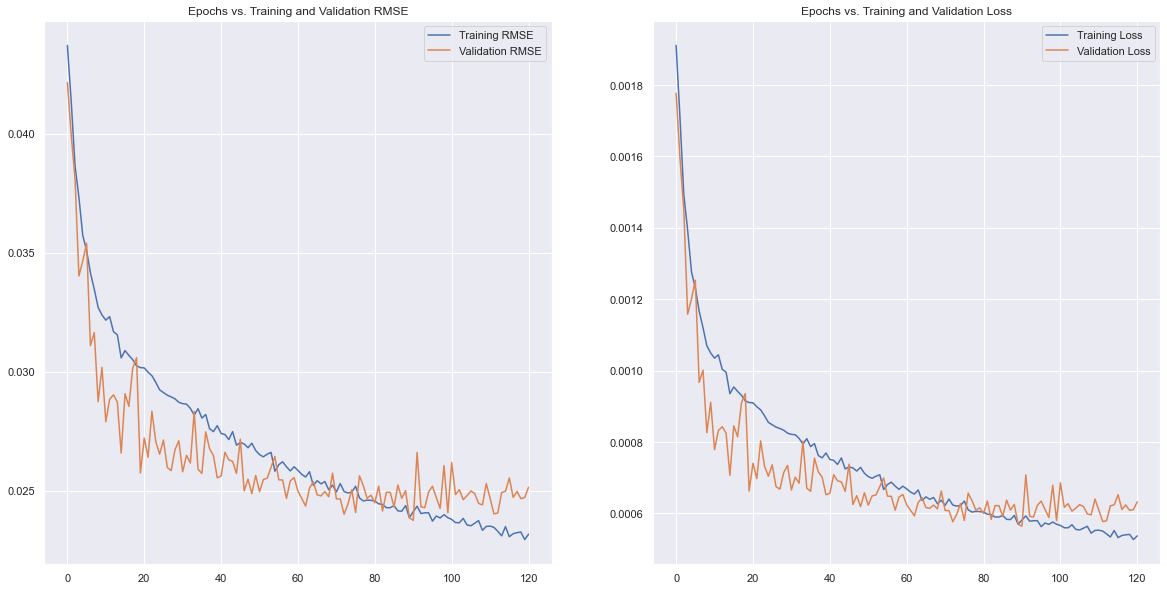

In [258]:
plot_model_rmse_and_loss(history)

In [259]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

#rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv, multivariate_stacked_lstm_forecast))
#print('RMSE of hour-ahead electricity price multivariate Stacked LSTM forecast: {}'.format(round(rmse_mult_stacked_lstm, 3)))

add_to_perf_dict('stacked lstm', y_test_inv, multivariate_stacked_lstm_forecast)

125/125 [==============================] - 9s 63ms/step


mse      rmse       mae       mape        r2
xbg           4.910046  2.215862  1.653383  99.853164  0.928144
lstm          5.406305  2.325146  1.752659  99.568938  0.920881
stacked lstm  5.148477  2.269026  1.754410  99.619936  0.924655

#### CNN

In [260]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [261]:
history = multivariate_cnn.fit(train, epochs=500,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/500
845/845 [==============================] - 5s 5ms/step - loss: 0.0134 - root_mean_squared_error: 0.1085 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0714
Epoch 2/500
845/845 [==============================] - 4s 5ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 3/500
845/845 [==============================] - 4s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
Epoch 4/500
845/845 [==============================] - 4s 5ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 5/500
845/845 [==============================] - 4s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 6/500
845/845 [==============================] - 4s 5ms/step - loss: 8.3888e-04 - root_mean_squared_error: 0.0290 - val_loss: 0.0

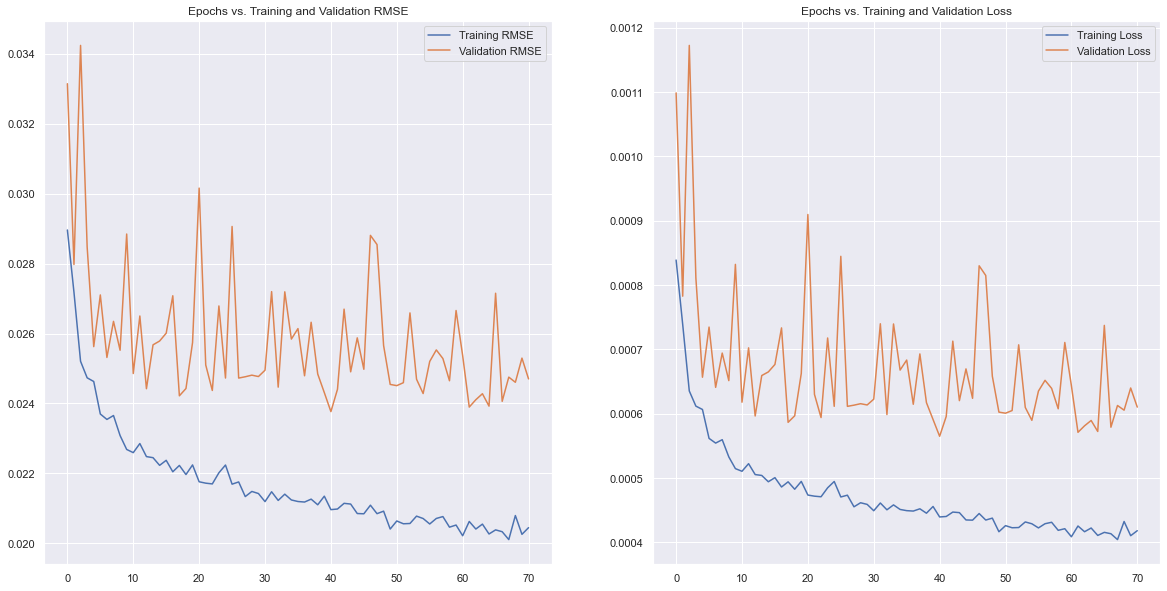

In [262]:
plot_model_rmse_and_loss(history)

In [263]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

#rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv, multivariate_cnn_forecast))
#print('RMSE of hour-ahead electricity price multivariate CNN forecast: {}'.format(round(rmse_mult_cnn, 3)))

add_to_perf_dict('cnn', y_test_inv, multivariate_cnn_forecast)

125/125 [==============================] - 0s 3ms/step


mse      rmse       mae       mape        r2
xbg           4.910046  2.215862  1.653383  99.853164  0.928144
lstm          5.406305  2.325146  1.752659  99.568938  0.920881
stacked lstm  5.148477  2.269026  1.754410  99.619936  0.924655
cnn           5.087853  2.255627  1.708168  99.873813  0.925542

#### CNN-LSTM

In [264]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Dropout(0.4),
    LSTM(100, return_sequences=True),
    Dropout(0.4),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [265]:
history = multivariate_cnn_lstm.fit(train, epochs=500,
                                    validation_data=validation,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

Epoch 1/500
845/845 [==============================] - 62s 71ms/step - loss: 0.0141 - root_mean_squared_error: 0.1111 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 2/500
845/845 [==============================] - 69s 81ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0675
Epoch 3/500
845/845 [==============================] - 72s 85ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0538
Epoch 4/500
845/845 [==============================] - 65s 77ms/step - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 5/500
845/845 [==============================] - 68s 81ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 6/500
845/845 [==============================] - 63s 75ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_l

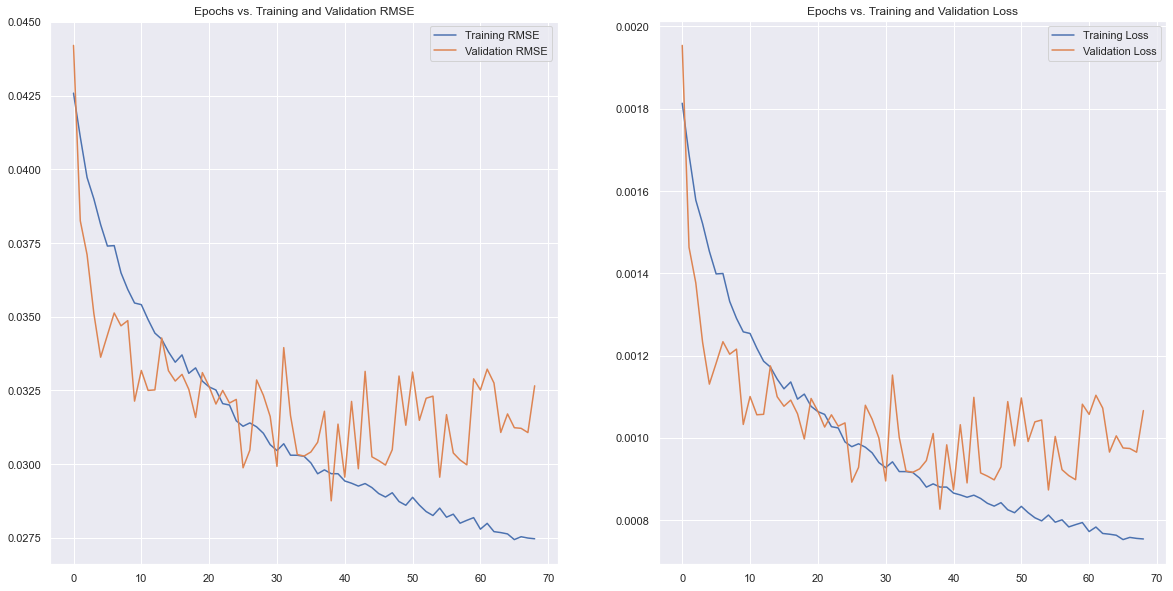

In [266]:
plot_model_rmse_and_loss(history)

In [267]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

#rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv, multivariate_cnn_lstm_forecast))
#print('RMSE of hour-ahead electricity price multivariate CNN-`LSTM forecast: {}'.format(round(rmse_mult_cnn_lstm, 3)))

add_to_perf_dict('cnn_lstm', y_test_inv, multivariate_cnn_lstm_forecast)

125/125 [==============================] - 3s 20ms/step


mse      rmse       mae       mape        r2
xbg           4.910046  2.215862  1.653383  99.853164  0.928144
lstm          5.406305  2.325146  1.752659  99.568938  0.920881
stacked lstm  5.148477  2.269026  1.754410  99.619936  0.924655
cnn           5.087853  2.255627  1.708168  99.873813  0.925542
cnn_lstm      7.557363  2.749066  2.117687  99.583753  0.889402

#### Time-distributed MLP

In [268]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=2e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [269]:
history = multivariate_mlp.fit(train, epochs=500,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/500
845/845 [==============================] - 17s 20ms/step - loss: 0.0074 - root_mean_squared_error: 0.0813 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 2/500
845/845 [==============================] - 17s 20ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
Epoch 3/500
845/845 [==============================] - 16s 19ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0316
Epoch 4/500
845/845 [==============================] - 16s 19ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336 - val_loss: 9.8259e-04 - val_root_mean_squared_error: 0.0313
Epoch 5/500
845/845 [==============================] - 15s 18ms/step - loss: 9.9281e-04 - root_mean_squared_error: 0.0315 - val_loss: 9.0136e-04 - val_root_mean_squared_error: 0.0300
Epoch 6/500
845/845 [==============================] - 14s 16ms/step - loss: 9.0115e-04 - root_mean_squared_error

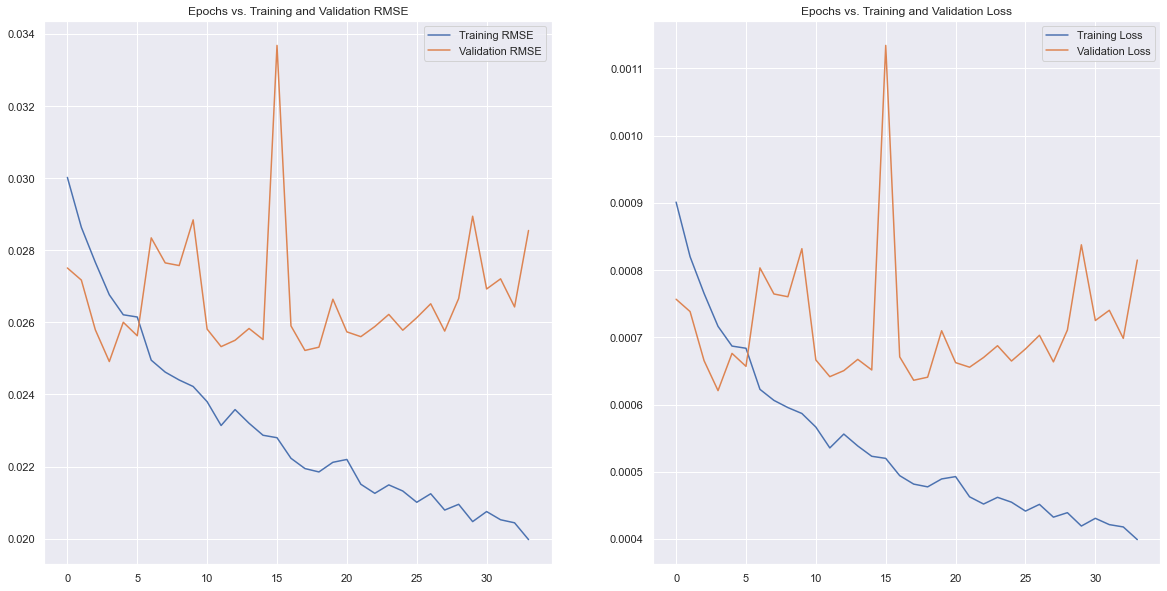

In [270]:
plot_model_rmse_and_loss(history)

In [271]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

#rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv, multivariate_mlp_forecast))
#print('RMSE of hour-ahead electricity price multivariate MLP forecast: {}'.format(round(rmse_mult_mlp, 3)))

add_to_perf_dict('multivariate MLP', y_test_inv, multivariate_mlp_forecast)

125/125 [==============================] - 1s 7ms/step


mse      rmse       mae       mape        r2
xbg               4.910046  2.215862  1.653383  99.853164  0.928144
lstm              5.406305  2.325146  1.752659  99.568938  0.920881
stacked lstm      5.148477  2.269026  1.754410  99.619936  0.924655
cnn               5.087853  2.255627  1.708168  99.873813  0.925542
cnn_lstm          7.557363  2.749066  2.117687  99.583753  0.889402
multivariate MLP  6.312848  2.512538  1.937310  99.586929  0.907615

#### Encoder-Decoder

In [272]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    Dropout(0.3)
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.3)
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dropout(0.3)
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

SyntaxError: invalid syntax (<ipython-input-272-6398696b5964>, line 6)

In [ ]:
history = encoder_decoder.fit(train, epochs=500,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/500
845/845 [==============================] - 23s 23ms/step - loss: 0.0045 - root_mean_squared_error: 0.0631 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0485
Epoch 2/500
845/845 [==============================] - 21s 25ms/step - loss: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 3/500
845/845 [==============================] - 20s 24ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 4/500
845/845 [==============================] - 20s 24ms/step - loss: 9.3572e-04 - root_mean_squared_error: 0.0306 - val_loss: 8.1445e-04 - val_root_mean_squared_error: 0.0285
Epoch 5/500
845/845 [==============================] - 20s 23ms/step - loss: 8.0707e-04 - root_mean_squared_error: 0.0284 - val_loss: 9.1890e-04 - val_root_mean_squared_error: 0.0303
Epoch 6/500
845/845 [==============================] - 20s 24ms/step - loss: 6.9288e-04 - root_mean_squared_e

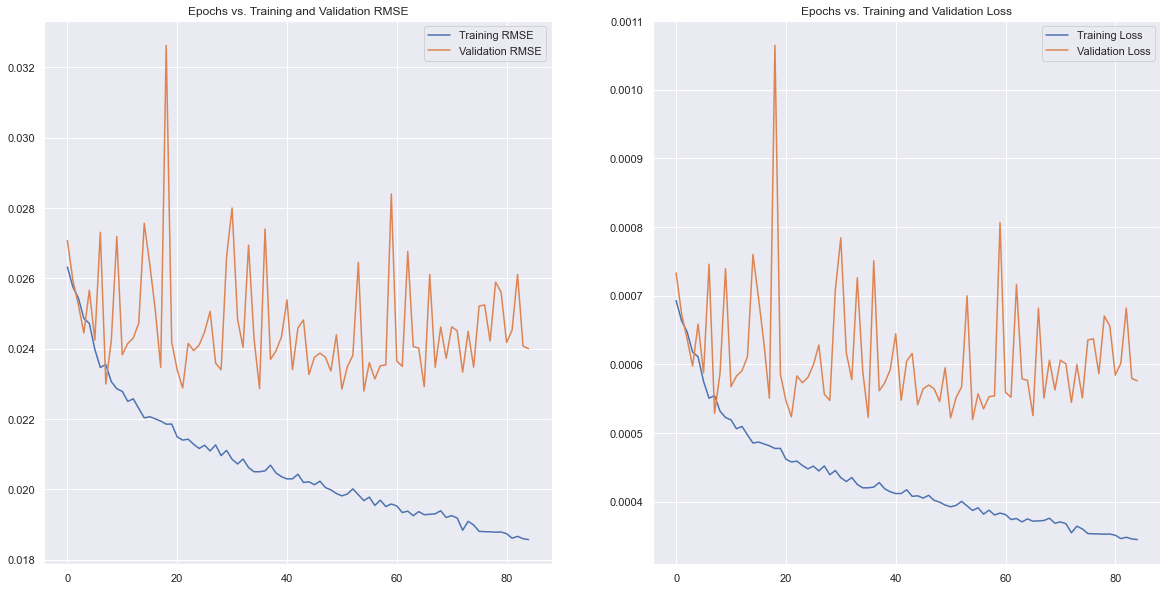

In [ ]:
plot_model_rmse_and_loss(history)

In [ ]:
encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

#rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv, encoder_decoder_forecast))
#print('RMSE of hour-ahead electricity price Encoder-Decoder forecast: {}'.format(round(rmse_encoder_decoder, 3)))

add_to_perf_dict('encoder decoder', y_test_inv, encoder_decoder_forecast)

125/125 [==============================] - 3s 17ms/step
RMSE of hour-ahead electricity price Encoder-Decoder forecast: 2.264


In [275]:
pd.DataFrame(perf_dict).T.sort_values(by='rmse', ascending=True)

mse      rmse       mae       mape        r2
xbg               4.910046  2.215862  1.653383  99.853164  0.928144
cnn               5.087853  2.255627  1.708168  99.873813  0.925542
stacked lstm      5.148477  2.269026  1.754410  99.619936  0.924655
lstm              5.406305  2.325146  1.752659  99.568938  0.920881
multivariate MLP  6.312848  2.512538  1.937310  99.586929  0.907615
cnn_lstm          7.557363  2.749066  2.117687  99.583753  0.889402